In [ ]:
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path(r"D:\Documents\Skripsi\demand-forecasting")
RAW_DIR  = PROJECT_ROOT / "data" / "data_raw"
EKS_DIR  = PROJECT_ROOT / "data" / "data_eks"
STD_DIR  = PROJECT_ROOT / "data" / "standardized"
OUT_DIR  = PROJECT_ROOT / "outputs"
DATASET15_DIR = PROJECT_ROOT / "data" / "dataset_15"
EDA15_DIR = OUT_DIR / "eda_dataset_15"
for d in [STD_DIR, OUT_DIR, DATASET15_DIR, EDA15_DIR]:
    d.mkdir(parents=True, exist_ok=True)

FILE_LIST = [
    RAW_DIR / "02A_Medan.xlsx",
    RAW_DIR / "05A_Padang.xlsx",
    RAW_DIR / "13A_Bekasi.xlsx",
    RAW_DIR / "13I_Bandung.xlsx",
    RAW_DIR / "14A_Tegal.xlsx",
    RAW_DIR / "16C_Surabaya.xlsx",
    RAW_DIR / "17A_Bali.xlsx",
    RAW_DIR / "23A_Samarinda.xlsx",
    RAW_DIR / "29A_Kendari.xlsx",
]
AREA_MAP = { '02A':'1A','05A':'1B','13A':'02','13I':'3','14A':'04','16C':'05','17A':'08','23A':'07','29A':'06' }

WIN_START = pd.Timestamp("2021-01-01")
TRAIN_END = pd.Timestamp("2024-05-01")
TEST_START = pd.Timestamp("2024-06-01")
TEST_END   = pd.Timestamp("2024-10-01")

F_EVENTS  = EKS_DIR / "event_gatering.xlsx"
F_HOL     = EKS_DIR / "hari_libur_nasional.xlsx"
F_RAIN_16 = EKS_DIR / "curah_hujan_Surabaya.xlsx"

SKU_16C_VALID_2023 = [
    "BUVW001KSW","DOPQ001K002","BKLM200CHAR","BKLM200CPOX","EVWX200CHAR",
    "BKLM001KHAR","BKLM001KPOX","DOPQ004K002","DOPQ001K009","BUVW001KSB",
    "BNOP400CPOX","FIJK250C","CKLM001KS600","ATUV005KSW","BVWX001KA",
    "CFGH001K711","BUVW001K192","EVW001KGRE",
]
SKU_23A_KEEP_MAY24 = {
    "AUVW001KA","AUVW001KASP","BKLM200CHAR","BKLM200CPOX","BNOP400CHAR",
    "BNOP400CPOX","BUVW001KSB","BUVW001KSW","BUVW200CSW","FIJK250C",
}

In [ ]:
def load_sales_monthly(files, area_map):
    dfs = []
    for f in files:
        df = pd.read_excel(f).rename(columns={
            "Posting Date":  "date",
            "Location Code": "cabang_raw",
            "SKU":           "sku",
            "Quantity":      "qty_raw",
        })

        df["qty"] = pd.to_numeric(df["qty_raw"], errors="coerce")
        df = df.dropna(subset=["qty"])

        # mapping area dan cabang 
        df["cabang"] = (
            df["cabang_raw"]
            .astype(str)
            .str.split("-")
            .str[0]
            .str.strip()
        )
        df["area"] = df["cabang"].map(area_map).fillna(df["cabang"])

        # periode bulanan 
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.dropna(subset=["date"])
        df["periode"] = df["date"].dt.to_period("M").dt.to_timestamp()

        # agregasi NETTO per bulan (shipment + retur)
        g = (
            df.groupby(["periode", "area", "cabang", "sku"], as_index=False)
              .agg(qty_net=("qty", "sum"))
        )

        # 5) ubah ke "demand" positif:
        #    - kalau qty_net = -40  -> demand = 40
        #    - kalau qty_net = +10  -> demand = 0 (lebih banyak retur)
        g["qty"] = -g["qty_net"]
        g.loc[g["qty"] < 0, "qty"] = 0.0
        g = g.drop(columns=["qty_net"])

        dfs.append(g)

    out = (
        pd.concat(dfs, ignore_index=True)
          .sort_values(["cabang", "sku", "periode"])
          .reset_index(drop=True)
    )
    return out[["periode", "area", "cabang", "sku", "qty"]]


sales_m = load_sales_monthly(FILE_LIST, AREA_MAP)

# area exceptions (tetap seperti sebelumnya)
m_16_2023 = (sales_m["cabang"] == "16C") & (sales_m["periode"].dt.year == 2023)
sales_m = pd.concat(
    [
        sales_m[~m_16_2023],
        sales_m[m_16_2023 & (sales_m["sku"].isin(SKU_16C_VALID_2023))],
    ],
    ignore_index=True,
)

m_23a_may24 = (sales_m["cabang"] == "23A") & (sales_m["periode"] == pd.Timestamp("2024-05-01"))
sales_m = pd.concat(
    [
        sales_m[~m_23a_may24],
        sales_m[m_23a_may24 & (sales_m["sku"].isin(SKU_23A_KEEP_MAY24))],
    ],
    ignore_index=True,
)

sales_m = sales_m.sort_values(["cabang", "sku", "periode"]).reset_index(drop=True)
sales_m.to_csv(STD_DIR / "sales_monthly_after_area_exceptions.csv", index=False)


IMPUTE 0, IS_ACTIVE, IS_TRAIN/TEST

In [5]:
def make_windowed_panel(df, area_map):
    out = []
    for (cab, sku), g in df.groupby(["cabang","sku"], sort=False):
        g = g.sort_values("periode")
        cal = pd.date_range(g["periode"].min(), g["periode"].max(), freq="MS")
        idx = pd.MultiIndex.from_product([[cab], [sku], cal], names=["cabang","sku","periode"])
        g2 = (g.set_index(["cabang","sku","periode"]).reindex(idx).reset_index())
        exist = set(zip(g["cabang"], g["sku"], g["periode"]))
        g2["qty"] = pd.to_numeric(g2["qty"], errors="coerce").fillna(0.0)
        g2["imputed"] = [0 if (cab, sku, p) in exist else 1 for p in g2["periode"]]
        g2["area"] = g2["cabang"].map(area_map).fillna(g2["cabang"])
        nz_idx = g2.index[g2["qty"] != 0]
        if len(nz_idx):
            left, right = int(nz_idx.min()), int(nz_idx.max())
            g2["is_active"] = 0
            g2.loc[left:right, "is_active"] = 1
        else:
            g2["is_active"] = 0
        out.append(g2[["periode","area","cabang","sku","qty","imputed","is_active"]])
    return (pd.concat(out, ignore_index=True)
              .sort_values(["cabang","sku","periode"])
              .reset_index(drop=True))

panel = make_windowed_panel(sales_m, AREA_MAP)

def _nonzero_bounds(g):
    nz = g.loc[g["qty"] != 0, "periode"]
    if len(nz):
        return pd.Series({"train_start": nz.min(), "nz_last": nz.max()})
    else:
        return pd.Series({"train_start": pd.NaT, "nz_last": pd.NaT})

nz_bounds = (panel.groupby(["cabang","sku"], sort=False).apply(_nonzero_bounds).reset_index())
panel = panel.merge(nz_bounds, on=["cabang","sku"], how="left")

panel["is_train"] = (
    (panel["is_active"]==1) &
    panel["train_start"].notna() &
    (panel["periode"] >= panel["train_start"]) &
    (panel["periode"] <= TRAIN_END)
).astype(int)

panel["is_test"] = (
    (panel["is_active"]==1) &
    (panel["periode"] >= TEST_START) &
    (panel["periode"] <= TEST_END)
).astype(int)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16660\2836650695.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nz_bounds = (panel.groupby(["cabang","sku"], sort=False).apply(_nonzero_bounds).reset_index())


LOAD EKSOGEN & MERGE

In [6]:
from pathlib import Path
import pandas as pd
import numpy as np
import re

# =========================================================
# 0. Path & Konfigurasi
# =========================================================

PROJECT_ROOT = Path(r"D:\Documents\Skripsi\demand-forecasting")
RAW_DIR  = PROJECT_ROOT / "data" / "data_raw"
EKS_DIR  = PROJECT_ROOT / "data" / "data_eks"
STD_DIR  = PROJECT_ROOT / "data" / "standardized"

STD_DIR.mkdir(parents=True, exist_ok=True)

# file RAW eksogen
F_EVENTS  = EKS_DIR / "event_gatering.xlsx"
F_HOL     = EKS_DIR / "hari_libur_nasional.xlsx"
F_RAIN_16 = EKS_DIR / "curah_hujan_Surabaya.xlsx"

# panel DIASUMSIKAN sudah ada:
# kolom minimal: periode (datetime), cabang, sku, qty, is_train, is_test, ...


# =========================================================
# 1. Helper Functions
# =========================================================

def parse_date_series(x, fmt=None):
    """
    Convert various date formats (string or Excel serial) to datetime.
    """
    try:
        if hasattr(x, "dtype") and np.issubdtype(x.dtype, np.number):
            return pd.to_datetime(x, origin="1899-12-30", unit="D", errors="coerce")
    except Exception:
        pass
    return pd.to_datetime(x, format=fmt, errors="coerce") if fmt else pd.to_datetime(x, errors="coerce")


def _to_month_start(s):
    """
    Convert any date to month start (YYYY-MM-01).
    """
    s = pd.to_datetime(s, errors="coerce")
    return s.dt.to_period("M").dt.to_timestamp()


# =========================================================
# 2. Load Event Gathering (any format) -> bulanan long
# =========================================================

def load_events_any(xlsx_path):
    df = pd.read_excel(xlsx_path)
    df.columns = [str(c).strip().lower() for c in df.columns]

    date_candidates = {
        "gatering date", "gathering date", "periode", "period",
        "month", "bulan", "date", "tanggal"
    }
    date_col = next((c for c in df.columns if c in date_candidates), None) or df.columns[0]

    # format long vs wide
    is_long = ("cabang" in df.columns) and any(c in df.columns for c in ["event", "event_flag", "eventflag"])
    if is_long:
        df = df.rename(columns={
            "event": "event_flag",
            "eventflag": "event_flag",
            date_col: "periode"
        })
        ev = df[["periode", "cabang", "event_flag"]].copy()
    else:
        tmp = df.rename(columns={date_col: "periode"})
        value_cols = [c for c in tmp.columns if c != "periode" and tmp[c].notna().any()]
        ev = tmp.melt(
            id_vars=["periode"],
            value_vars=value_cols,
            var_name="cabang",
            value_name="event_flag"
        )

    ev["periode"] = _to_month_start(ev["periode"])
    ev = ev.dropna(subset=["periode"])
    ev["cabang"] = (
        ev["cabang"].astype(str)
        .str.strip()
        .str.upper()
        .str.replace(r"[-_].*$", "", regex=True)
    )
    ev["event_flag"] = (
        pd.to_numeric(ev["event_flag"], errors="coerce")
        .fillna(0)
        .astype(int)
        .clip(lower=0)
    )
    ev = (
        ev[["periode", "cabang", "event_flag"]]
        .drop_duplicates()
        .sort_values(["cabang", "periode"])
        .reset_index(drop=True)
    )

    out_path = STD_DIR / "events_monthly_long.csv"
    ev.to_csv(out_path, index=False)
    print("Saved events ->", out_path)

    return ev


# =========================================================
# 3. Load Holidays Monthly -> bulanan
# =========================================================

def load_holidays_monthly_strict(path_like):
    hol = pd.read_csv(path_like) if str(path_like).lower().endswith(".csv") else pd.read_excel(path_like)
    hol.columns = [str(c).strip().lower() for c in hol.columns]

    if "periode" not in hol.columns:
        c0 = hol.columns[0]
        hol = hol.rename(columns={c0: "periode"})
    if "holiday_count" not in hol.columns:
        c1 = next((c for c in hol.columns if c != "periode"), None)
        if c1:
            hol = hol.rename(columns={c1: "holiday_count"})
        else:
            hol["holiday_count"] = 0

    hol["periode"] = _to_month_start(hol["periode"])
    hol = hol.dropna(subset=["periode"])
    hol["holiday_count"] = (
        pd.to_numeric(hol["holiday_count"], errors="coerce")
        .fillna(0)
        .astype(int)
        .clip(0, 31)
    )
    hol = (
        hol[["periode", "holiday_count"]]
        .drop_duplicates()
        .sort_values("periode")
        .reset_index(drop=True)
    )

    out_path = STD_DIR / "holidays_monthly_strict.csv"
    hol.to_csv(out_path, index=False)
    print("Saved holidays ->", out_path)

    return hol


# =========================================================
# 4. Load Rainfall (Surabaya 16C) Harian -> Bulanan
# =========================================================

def load_rain_16c(xlsx_path):
    rf = pd.read_excel(xlsx_path)
    rf.columns = [c.strip().lower() for c in rf.columns]

    # cari kolom tanggal & hujan
    date_col = next((c for c in rf.columns if "tanggal" in c or "date" in c), rf.columns[0])
    rain_col = next((c for c in rf.columns if "rr" in c or "rain" in c), None)
    if rain_col is None:
        raise ValueError("Kolom curah hujan (RR / rain) tidak ditemukan di file Excel.")

    rf = rf.rename(columns={date_col: "date", rain_col: "rain"})

    # parse tanggal fleksibel
    rf["date"] = pd.to_datetime(rf["date"], errors="coerce", dayfirst=True)
    if rf["date"].isna().all():
        rf["date"] = pd.to_datetime(
            pd.to_numeric(rf["date"], errors="coerce"),
            origin="1899-12-30",
            unit="D",
            errors="coerce"
        )

    rf = rf.dropna(subset=["date"])
    if rf.empty:
        raise ValueError(f"Tidak ada tanggal valid di {xlsx_path}")

    # bersihkan curah hujan
    rf["rain"] = pd.to_numeric(rf["rain"], errors="coerce")
    rf.loc[(rf["rain"] == 8888) | (rf["rain"] < 0), "rain"] = np.nan

    # daily average per tanggal
    daily = (
        rf.groupby("date", as_index=False)["rain"]
        .mean()
        .sort_values("date")
    )
    if daily.empty:
        raise ValueError(f"File {xlsx_path} tidak punya data curah hujan valid.")

    # interpolasi untuk tanggal hilang
    full_days = pd.date_range(daily["date"].min(), daily["date"].max(), freq="D")
    df1 = daily.set_index("date").reindex(full_days)
    df1.index.name = "date"

    df1["rain_interp"] = df1["rain"].interpolate("linear", limit_direction="both").clip(lower=0)

    # overwrite ke satu kolom rain
    df1["rain"] = df1["rain_interp"]
    df1 = df1.drop(columns=["rain_interp"])

    d2 = df1.reset_index()
    d2["periode"] = d2["date"].dt.to_period("M").dt.to_timestamp()

    rain_16 = (
        d2.groupby("periode", as_index=False)["rain"]
        .sum()
        .rename(columns={"rain": "rainfall"})
        .sort_values("periode")
    )
    rain_16["cabang"] = "16C"
    rain_16 = rain_16[["periode", "cabang", "rainfall"]]

    out_path = STD_DIR / "rain_16c_monthly.csv"
    rain_16.to_csv(out_path, index=False)
    print("Saved rainfall 16C ->", out_path)

    return rain_16


# =========================================================
# 5. Integrasi ke Panel & Feature Builder
# =========================================================

# 5.1 Load eksternal (bulanan)
events  = load_events_any(F_EVENTS)
hol     = load_holidays_monthly_strict(F_HOL)
rain_16 = load_rain_16c(F_RAIN_16)

# 5.2 Merge ke panel (level cabang + sku + periode)
panel_exog = (
    panel
    .merge(events,  on=["periode", "cabang"], how="left")
    .merge(hol,     on="periode",            how="left")
    .merge(rain_16, on=["periode", "cabang"], how="left")
    .sort_values(["cabang", "sku", "periode"])
    .reset_index(drop=True)
)


# ---------- Satukan duplikat & tipe aman ----------
def squash_duplicates(df, target_cols):
    for col in target_cols:
        idxs = [i for i, name in enumerate(df.columns) if name == col]
        if len(idxs) > 1:
            block = df.iloc[:, idxs].apply(pd.to_numeric, errors="coerce")
            df[col] = block.bfill(axis=1).iloc[:, 0]
            drop_cols = [df.columns[i] for i in idxs[1:]]
            df.drop(columns=drop_cols, inplace=True)
    return df

panel_exog = squash_duplicates(panel_exog, ["event_flag", "holiday_count", "rainfall"])

panel_exog["event_flag"]    = pd.to_numeric(panel_exog["event_flag"], errors="coerce").fillna(0).astype(int)
panel_exog["holiday_count"] = pd.to_numeric(panel_exog["holiday_count"], errors="coerce").fillna(0).astype(int)
panel_exog["rainfall"]      = pd.to_numeric(panel_exog["rainfall"], errors="coerce").fillna(0.0)

print("Merged panel with exogenous variables:")
print(panel_exog.head(10))


# ---------- Exog lag1 TANPA fill setelah shift ----------
for c in ["event_flag", "holiday_count", "rainfall"]:
    lagc = f"{c}_lag1"
    if lagc in panel_exog.columns:
        panel_exog.drop(columns=[lagc], inplace=True)
    panel_exog[lagc] = panel_exog.groupby(["cabang", "sku"], sort=False)[c].shift(1)


# ---------- Qty lags dan rolling ----------
MAX_LAG = 12
for k in range(1, MAX_LAG + 1):
    panel_exog[f"qty_lag{k}"] = panel_exog.groupby(["cabang", "sku"])["qty"].shift(k)

for w in [3, 6, 12]:
    panel_exog[f"qty_rollmean_{w}"] = (
        panel_exog.groupby(["cabang", "sku"])["qty"]
        .transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
    )
    panel_exog[f"qty_rollstd_{w}"] = (
        panel_exog.groupby(["cabang", "sku"])["qty"]
        .transform(lambda s: s.shift(1).rolling(w, min_periods=2).std(ddof=1))
    )


# ---------- Spike detection kontekstual ----------
def detect_spikes_contextual(df, z_th=3.0, iqr_k=1.5, roll_k=3, dev_k=3.0, event_quant=0.90):
    outs = []
    for (cab, sku), g in df.groupby(["cabang", "sku"], sort=False):
        g = g.sort_values("periode").copy()
        x = g["qty"].astype(float).values
        event = g["event_flag"].fillna(0).values
        holiday = g["holiday_count"].fillna(0).values
        rainfall = g["rainfall"].fillna(0.0).values if cab == "16C" else np.zeros_like(x)

        # robust z
        med = np.nanmedian(x)
        mad = np.nanmedian(np.abs(x - med))
        mad = mad if mad > 0 else 1.0
        zrob = 0.6745 * (x - med) / mad
        out_z = (np.abs(zrob) >= z_th)

        # IQR
        q1, q3 = np.nanpercentile(x, [25, 75])
        iqr = q3 - q1
        lo, hi = q1 - iqr_k * iqr, q3 + iqr_k * iqr
        out_iqr = (x < lo) | (x > hi)

        # rolling median dev (no-peek)
        xs = pd.Series(x)
        rm = xs.shift(1).rolling(roll_k, min_periods=1).median().values
        dev = (xs.sub(pd.Series(rm)).abs()
               .shift(1).rolling(roll_k, min_periods=1).median().values)
        fallback = np.nanmedian(dev[dev > 0]) if np.any(dev > 0) else 1.0
        dev = np.where((dev == 0) | np.isnan(dev), fallback, dev)
        out_roll = (np.abs(x - rm) > dev_k * dev)

        # voting
        spike_raw = ((out_z.astype(int) + out_iqr.astype(int) + out_roll.astype(int)) >= 2)

        # konteks: event/holiday/rain kuat
        is_ctx = (event > 0) | (holiday > 0) | ((cab == "16C") & (rainfall > 50))
        adjusted = np.zeros_like(spike_raw, dtype=bool)
        ev_ref = x[is_ctx]
        ev_q = np.nanquantile(ev_ref, event_quant) if len(ev_ref) else np.nan

        for i, flag in enumerate(spike_raw):
            if not flag:
                continue
            if not is_ctx[i]:
                adjusted[i] = True
            else:
                if np.isnan(ev_q) or (x[i] > ev_q):
                    adjusted[i] = True

        h = g.copy()
        h["spike_flag"] = adjusted.astype(int)
        outs.append(h)
    return pd.concat(outs, ignore_index=True)


panel_exog = detect_spikes_contextual(panel_exog)


# ---------- Sample weight ----------
panel_exog["sample_weight"] = 1.0
panel_exog.loc[(panel_exog["is_train"] == 1) & (panel_exog["spike_flag"] == 1), "sample_weight"] = 0.8
panel_exog.loc[(panel_exog["is_train"] == 1) & (panel_exog["qty"] == 0), "sample_weight"] *= 0.7


# ---------- Kolom waktu ----------
panel_exog["month"] = panel_exog["periode"].dt.month
panel_exog["year"]  = panel_exog["periode"].dt.year
panel_exog["qtr"]   = panel_exog["periode"].dt.quarter


# ---------- Sanity checks singkat ----------
first = (
    panel_exog.sort_values(["cabang", "sku", "periode"])
              .groupby(["cabang", "sku"]).head(1)
)
viol_first = {
    c: int(first[c].notna().sum())
    for c in ["event_flag_lag1", "holiday_count_lag1", "rainfall_lag1"]
    if c in first.columns
}
print("Pelanggar first-row NaN (harus 0 semua):", viol_first)

# Curah hujan hanya untuk 16C
assert panel_exog.query("cabang!='16C' and rainfall>0").empty, "Rainfall bocor ke non-16C"


# ---------- Save panel_exog ----------
panel_exog_path = STD_DIR / "panel_exog_ready.csv"
panel_exog.to_csv(panel_exog_path, index=False)
print("Saved panel_exog_ready ->", panel_exog_path)


# ---------- Turunkan exog ke level cabang-periode untuk DB ----------
exog_monthly = (
    panel_exog
    .groupby(["periode", "cabang"])[["event_flag", "holiday_count", "rainfall"]]
    .max()
    .reset_index()
    .sort_values(["cabang", "periode"])
    .reset_index(drop=True)
)

exog_monthly_path = STD_DIR / "external_monthly_ready.csv"
exog_monthly.to_csv(exog_monthly_path, index=False)
print("Saved external_monthly_ready ->", exog_monthly_path)


Saved events -> D:\Documents\Skripsi\demand-forecasting\data\standardized\events_monthly_long.csv
Saved holidays -> D:\Documents\Skripsi\demand-forecasting\data\standardized\holidays_monthly_strict.csv
Saved rainfall 16C -> D:\Documents\Skripsi\demand-forecasting\data\standardized\rain_16c_monthly.csv
Merged panel with exogenous variables:
     periode area cabang          sku   qty  imputed  is_active train_start  \
0 2023-06-01   1A    02A  AHIJ005K701   4.0        0          1  2023-06-01   
1 2023-07-01   1A    02A  AHIJ005K701  12.0        0          1  2023-06-01   
2 2023-08-01   1A    02A  AHIJ005K701   7.0        0          1  2023-06-01   
3 2023-09-01   1A    02A  AHIJ005K701   0.0        1          1  2023-06-01   
4 2023-10-01   1A    02A  AHIJ005K701   8.0        0          1  2023-06-01   
5 2023-11-01   1A    02A  AHIJ005K701   0.0        1          1  2023-06-01   
6 2023-12-01   1A    02A  AHIJ005K701   0.0        1          1  2023-06-01   
7 2024-01-01   1A    02A  

In [7]:
print("Events unique months:", events["periode"].nunique())
print("Holidays months:", hol["periode"].nunique())
print("Rainfall 16C months:", rain_16["periode"].nunique())


Events unique months: 48
Holidays months: 48
Rainfall 16C months: 48


SELEKSI 15 SKU PER CABANG

In [8]:
# ---------- Seleksi seri: build_selection_window ----------

def build_selection_window(df, win_start, train_end):
    # window seleksi
    w = df.query("periode >= @win_start and periode <= @train_end").copy()

    # has_may24 (Mei 2024)
    has_may = (
        w.query("periode == @train_end")
         .groupby(["cabang","sku"], as_index=False)
         .size()
         .rename(columns={"size": "has_may24"})
    )

    # agregat dasar
    agg = (
        w.groupby(["cabang","sku"], as_index=False)
         .agg(
             n_months=("qty", "size"),
             nonzero_months=("qty", lambda s: (s > 0).sum()),
             total_qty=("qty", "sum"),
         )
    )

    # 12 bulan terakhir
    last12 = (
        w.sort_values(["cabang","sku","periode"])
         .groupby(["cabang","sku"], as_index=False)
         .agg(qty_12m=("qty", lambda s: s.tail(12).sum()))
    )

    # 6 bulan terakhir
    last6 = (
        w.sort_values(["cabang","sku","periode"])
         .groupby(["cabang","sku"], as_index=False)
         .agg(qty_6m=("qty", lambda s: s.tail(6).sum()))
    )

    # zero ratio & n_train dari is_train
    t = df.loc[df["is_train"] == 1].copy()

    zr = (
        t.groupby(["cabang","sku"], as_index=False)["qty"]
         .apply(lambda s: (s == 0).mean())
         .rename(columns={"qty": "zero_ratio_train"})
    )

    ntr = (
        t.groupby(["cabang","sku"], as_index=False)["qty"]
         .count()
         .rename(columns={"qty": "n_train"})
    )

    # last non-zero di train
    nz = (
        t.loc[t["qty"] > 0]
         .groupby(["cabang","sku"], as_index=False)["periode"]
         .max()
         .rename(columns={"periode": "last_nz"})
    )

    # merge semua
    info = (
        agg.merge(last12, on=["cabang","sku"], how="left")
           .merge(last6,  on=["cabang","sku"], how="left")
           .merge(has_may, on=["cabang","sku"], how="left")
           .merge(zr, on=["cabang","sku"], how="left")
           .merge(ntr, on=["cabang","sku"], how="left")
           .merge(nz, on=["cabang","sku"], how="left")
    )

    # bersihkan NaN
    info["has_may24"] = info["has_may24"].fillna(0).gt(0)
    for c in ["zero_ratio_train", "n_train", "qty_12m", "qty_6m"]:
        info[c] = info[c].fillna(0)

    # months_since_last_nz
    info["last_nz"] = pd.to_datetime(info["last_nz"], errors="coerce")

    train_end_per = train_end.to_period("M")

    mask = info["last_nz"].notna()
    last_nz_per = info.loc[mask, "last_nz"].dt.to_period("M")

    # selisih bulan
    diff_months = train_end_per.ordinal - last_nz_per.view("int64")

    info["months_since_last_nz"] = 999
    info.loc[mask, "months_since_last_nz"] = diff_months.values
    info["months_since_last_nz"] = info["months_since_last_nz"].astype("int64")
    info.loc[info["last_nz"].isna(), "months_since_last_nz"] = 999

    # alive_recent: masih hidup menjelang akhir window
    info["alive_recent"] = (
        (info["qty_6m"] > 0) &
        (info["months_since_last_nz"] <= 3)
    ).astype(int)

    return info


# ---------- Hitung info per seri ----------

info = build_selection_window(panel_exog, WIN_START, TRAIN_END)

print("Total seri unik:", len(info))
print("Contoh info per seri:")
print(info.head())

# ---------- Satu flag global: eligible_model (dipakai LGBM & TFT) ----------

info["eligible_model"] = (
    (info["n_months"] >= 36)        # minimal 3 tahun histori
    & (info["nonzero_months"] >= 10)    # tidak super jarang
    & (info["qty_12m"] > 0)             # 12 bulan terakhir masih hidup
    & (info["total_qty"] >= 30)         # tidak cuma jual 1–2 kali
    & (info["zero_ratio_train"] <= 0.7) # max 70% bulan = 0 di train
    & (info["has_may24"] == True)      # sinkron sampai Mei 2024
    & (info["alive_recent"] == 1)      # last_nz dekat train_end
).astype(int)

print("SKU eligible_model per cabang:")
print(info.query("eligible_model == 1").groupby("cabang")["sku"].nunique())

# ---------- selected15: top-15 per cabang dari eligible_model ----------

eligible_for_top = info.query("eligible_model == 1").copy()

eligible_for_top = eligible_for_top.sort_values(
    ["cabang","nonzero_months","qty_12m","total_qty"],
    ascending=[True, False, False, False]
)

selected15 = (
    eligible_for_top.groupby("cabang", as_index=False)
                   .head(15)[["cabang","sku"]]
                   .drop_duplicates()
                   .reset_index(drop=True)
)
selected15["selected15"] = 1

DATASET15_DIR.mkdir(parents=True, exist_ok=True)
selected15.to_csv(DATASET15_DIR / "selected_skus_15_per_cabang.csv", index=False)

print("Per cabang -> jumlah SKU selected15:")
print(selected15.groupby("cabang")["sku"].nunique())

# ---------- Merge flag ke panel_exog ----------

panel_exog = panel_exog.merge(
    info[["cabang","sku","eligible_model","alive_recent"]],
    on=["cabang","sku"],
    how="left"
)

panel_exog = panel_exog.merge(
    selected15[["cabang","sku","selected15"]],
    on=["cabang","sku"],
    how="left"
)

for c in ["eligible_model","alive_recent","selected15"]:
    panel_exog[c] = panel_exog[c].fillna(0).astype(int)

print("Ringkasan flag:")
print(panel_exog[["eligible_model","alive_recent","selected15"]].describe())

# ---------- Save final panel + base dataset ----------

# panel lengkap (dipakai sistem + EDA)
out_path = STD_DIR / "panel_exog_ready.csv"
panel_exog.to_csv(out_path, index=False)
print("Saved final panel_exog with flags to:", out_path)

# base untuk semua seri eligible (nama disamakan dengan script EDA kamu)
model_base_path = STD_DIR / "panel_model_eligible_all.csv"
panel_exog.query("eligible_model == 1").to_csv(model_base_path, index=False)
print("Saved modeling base (eligible_model == 1) to:", model_base_path)

# dataset khusus 15 SKU per cabang (dipakai SARIMAX / LGBM 15)
panel15_path = DATASET15_DIR / "panel_exog_selected15.csv"
panel_exog.query("selected15 == 1").to_csv(panel15_path, index=False)
print("Saved panel_exog_selected15 ->", panel15_path)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_16660\737064303.py:86: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  diff_months = train_end_per.ordinal - last_nz_per.view("int64")


Total seri unik: 18650
Contoh info per seri:
  cabang          sku  n_months  nonzero_months  total_qty  qty_12m  qty_6m  \
0    02A  AHIJ005K701        11               8       49.0     49.0    18.0   
1    02A  AHIJ005K702        11               9       76.0     76.0    24.0   
2    02A  AHIJ005K703        12              12      154.0    154.0    78.0   
3    02A  AHIJ005K704        12              11      111.0    111.0    64.0   
4    02A  AHIJ005K705         6               3       16.0     16.0    16.0   

   has_may24  zero_ratio_train  n_train    last_nz  months_since_last_nz  \
0      False          0.272727     11.0 2024-04-01                     1   
1      False          0.181818     11.0 2024-04-01                     1   
2       True          0.000000     12.0 2024-05-01                     0   
3       True          0.083333     12.0 2024-05-01                     0   
4      False          0.500000      6.0 2023-11-01                     6   

   alive_recent  
0    

In [10]:
panel_base = panel_exog.query("selected15==1").drop_duplicates(["cabang","sku"])
print(panel_base.groupby("cabang").size().sort_index())  # harus: 02A 15; 05A 15; 13A 10; 13I 15; 14A 15; 16C 15; 17A 10; 23A 10; 29A 15
print("Total seri:", len(panel_base))  


cabang
02A    15
05A    15
13A    10
13I    15
14A    15
16C    15
17A    10
23A    10
29A    15
dtype: int64
Total seri: 120


In [9]:
print(panel_exog.columns)


Index(['periode', 'area', 'cabang', 'sku', 'qty', 'imputed', 'is_active',
       'train_start', 'nz_last', 'is_train', 'is_test', 'event_flag',
       'holiday_count', 'rainfall', 'event_flag_lag1', 'holiday_count_lag1',
       'rainfall_lag1', 'qty_lag1', 'qty_lag2', 'qty_lag3', 'qty_lag4',
       'qty_lag5', 'qty_lag6', 'qty_lag7', 'qty_lag8', 'qty_lag9', 'qty_lag10',
       'qty_lag11', 'qty_lag12', 'qty_rollmean_3', 'qty_rollstd_3',
       'qty_rollmean_6', 'qty_rollstd_6', 'qty_rollmean_12', 'qty_rollstd_12',
       'spike_flag', 'sample_weight', 'month', 'year', 'qtr', 'eligible_model',
       'alive_recent', 'selected15'],
      dtype='object')


In [14]:
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
pd.set_option("display.width", None)
pd.set_option("display.max_columns", 50)

# ===================================================================
# PATH
# ===================================================================
PROJECT_ROOT     = Path(r"D:\Documents\Skripsi\demand-forecasting")
STD_DIR          = PROJECT_ROOT / "data" / "standardized"
DATASET15_DIR    = PROJECT_ROOT / "data" / "dataset_15"
DATASETFULL_DIR  = PROJECT_ROOT / "data" / "dataset_full"

DATASET15_DIR.mkdir(parents=True, exist_ok=True)
DATASETFULL_DIR.mkdir(parents=True, exist_ok=True)

# ===================================================================
# LOAD PANEL
# ===================================================================
panel_full = pd.read_csv(
    STD_DIR / "panel_model_eligible_all.csv",
    parse_dates=["periode"],
    low_memory=False
)

panel15 = pd.read_csv(
    DATASET15_DIR / "panel_exog_selected15.csv",
    parse_dates=["periode"]
)

print("panel_full rows:", len(panel_full))
print("panel15 rows    :", len(panel15))

# ===================================================================
# 0) SANITY CHECK SINGKAT
# ===================================================================
print("\nRANGE PERIODE panel_full")
print(panel_full["periode"].min(), "->", panel_full["periode"].max())

print("\nDuplikat (cabang,sku,periode) panel_full:",
      panel_full.duplicated(subset=["cabang","sku","periode"]).sum())

print("\nNA utama panel_full:")
print(panel_full[["qty","event_flag","holiday_count",
                 "rainfall_lag1","is_train","is_test"]].isna().sum())

# ===================================================================
# 1) HEALTH: SEMUA SKU ELIGIBLE (TRAIN ONLY)
# ===================================================================
pf_tr = panel_full.query("is_train == 1").copy()

def health_fn(g: pd.DataFrame) -> pd.Series:
    y = g["qty"].astype(float)
    return pd.Series({
        "n_train": len(g),
        "n_zero": int((y == 0).sum()),
        "zero_ratio": float((y == 0).mean()),
        "imputed_ratio": float(g["imputed"].mean()),
        "spike_ratio": float(g["spike_flag"].mean()),
        "qty_mean": float(y.mean()),
        "qty_median": float(y.median()),
        "qty_std": float(y.std(ddof=1)),
        "qty_min": float(y.min()),
        "qty_max": float(y.max()),
    })

health_full = (
    pf_tr.sort_values(["cabang","sku","periode"])
         .groupby(["cabang","sku"], as_index=False, group_keys=False)
         .apply(lambda g: health_fn(g.reset_index(drop=True)))
)

def bucket_scale(m):
    if m < 5:
        return "low"
    elif m < 50:
        return "medium"
    return "high"

def bucket_zero(z):
    if z <= 0.2:
        return "dense"
    elif z <= 0.5:
        return "semi_sparse"
    return "sparse"

health_full["scale_bucket"] = health_full["qty_median"].apply(bucket_scale)
health_full["zero_bucket"]  = health_full["zero_ratio"].apply(bucket_zero)

print("\nPreview health_full (top 10)")
print(health_full.head(10))

p_health_full = DATASETFULL_DIR / "eda_series_health_full.csv"
health_full.to_csv(p_health_full, index=False)
print("Saved:", p_health_full)

# ===================================================================
# 1B) RINGKASAN PER CABANG
# ===================================================================
cabang_profile = (
    health_full
    .groupby("cabang", as_index=False)
    .agg(
        n_sku=("sku","nunique"),
        median_zero_ratio=("zero_ratio","median"),
        mean_zero_ratio=("zero_ratio","mean"),
        median_qty_median=("qty_median","median"),
        mean_qty_median=("qty_median","mean"),
    )
)

print("\nPreview cabang_profile")
print(cabang_profile)

p_cbg_profile = DATASETFULL_DIR / "eda_cabang_profile_full.csv"
cabang_profile.to_csv(p_cbg_profile, index=False)
print("Saved:", p_cbg_profile)

# ===================================================================
# 1C) DISTRIBUSI BUCKET PER CABANG
# ===================================================================
bucket_pivot = (
    health_full
    .groupby(["cabang","scale_bucket","zero_bucket"])["sku"]
    .nunique()
    .reset_index(name="n_sku")
)

print("\nPreview bucket_pivot (top 20)")
print(bucket_pivot.head(20))

p_bucket = DATASETFULL_DIR / "eda_cabang_bucket_distribution_full.csv"
bucket_pivot.to_csv(p_bucket, index=False)
print("Saved:", p_bucket)

# ===================================================================
# 2) COVERAGE EXOG PER CABANG (TRAIN ONLY)
# ===================================================================
def exog_stats(g: pd.DataFrame) -> pd.Series:
    return pd.Series({
        "event_month_ratio": float((g["event_flag"] > 0).mean()),
        "mean_holiday_count": float(g["holiday_count"].mean()),
        "mean_rainfall_lag1": float(g["rainfall_lag1"].mean()),
        "rain_nz_ratio": float((g["rainfall_lag1"] > 0).mean()),
    })

exog_cabang = (
    pf_tr.groupby("cabang", as_index=False, group_keys=False)
         .apply(lambda g: exog_stats(g.reset_index(drop=True)))
)

print("\nPreview exog_cabang")
print(exog_cabang)

p_exog_cbg = DATASETFULL_DIR / "eda_exog_cabang_full.csv"
exog_cabang.to_csv(p_exog_cbg, index=False)
print("Saved:", p_exog_cbg)

# ===================================================================
# 3) HEALTH KHUSUS 15 SKU (TRAIN ONLY)
# ===================================================================
p15_tr = panel15.query("is_train == 1").copy()

def health15_fn(g: pd.DataFrame) -> pd.Series:
    y = g["qty"].astype(float)
    return pd.Series({
        "n_train": len(g),
        "zero_ratio": float((y == 0).mean()),
        "imputed_ratio": float(g["imputed"].mean()),
        "spike_ratio": float(g["spike_flag"].mean()),
        "qty_mean": float(y.mean()),
        "qty_median": float(y.median()),
        "qty_std": float(y.std(ddof=1)),
        "qty_min": float(y.min()),
        "qty_max": float(y.max()),
    })

health15 = (
    p15_tr.sort_values(["cabang","sku","periode"])
          .groupby(["cabang","sku"], as_index=False, group_keys=False)
          .apply(lambda g: health15_fn(g.reset_index(drop=True)))
)

print("\nPreview health15 (top 10)")
print(health15.head(10))

p_health15 = DATASET15_DIR / "eda_health_selected15.csv"
health15.to_csv(p_health15, index=False)
print("Saved:", p_health15)

health15_cbg = (
    health15
    .groupby("cabang", as_index=False)
    .agg(
        n_sku=("sku","nunique"),
        median_zero_ratio=("zero_ratio","median"),
        median_qty_median=("qty_median","median"),
    )
)

print("\nPreview health15_cbg")
print(health15_cbg)

p_health15_cbg = DATASET15_DIR / "eda_health_selected15_by_cabang.csv"
health15_cbg.to_csv(p_health15_cbg, index=False)
print("Saved:", p_health15_cbg)

# ===================================================================
# 4) KORELASI QTY vs EXOG (15 SKU, TRAIN ONLY)
# ===================================================================
def safe_corr(a: pd.Series, b: pd.Series) -> float:
    s = pd.concat([a, b], axis=1).dropna()
    if len(s) < 6 or s.iloc[:, 0].std() == 0 or s.iloc[:, 1].std() == 0:
        return np.nan
    return float(s.corr().iloc[0, 1])

exogs = [
    "event_flag",
    "event_flag_lag1",
    "holiday_count",
    "holiday_count_lag1",
    "rainfall_lag1",
]

rows = []
for (cab, sku), g in p15_tr.groupby(["cabang","sku"], sort=False):
    qty = pd.to_numeric(g["qty"], errors="coerce")
    for ex in exogs:
        rows.append({
            "cabang":  cab,
            "sku":     sku,
            "feature": ex,
            "corr":    safe_corr(qty, pd.to_numeric(g[ex], errors="coerce")),
        })

corr15 = pd.DataFrame(rows)

print("\nPreview corr15 (top 20)")
print(corr15.head(20))

p_corr15 = DATASET15_DIR / "eda_corr_qty_vs_exog_selected15.csv"
corr15.to_csv(p_corr15, index=False)
print("Saved:", p_corr15)

corr15_summary = (
    corr15.assign(abs_corr=lambda d: d["corr"].abs())
          .groupby("feature", as_index=False)
          .agg(
              n_nonnull=("abs_corr", lambda s: int(s.notna().sum())),
              median_abs_corr=("abs_corr","median"),
              max_abs_corr=("abs_corr","max"),
          )
)

print("\nPreview corr15_summary")
print(corr15_summary)

p_corr15_sum = DATASET15_DIR / "eda_corr_exog_summary_selected15.csv"
corr15_summary.to_csv(p_corr15_sum, index=False)
print("Saved:", p_corr15_sum)


panel_full rows: 158863
panel15 rows    : 4965

RANGE PERIODE panel_full
2021-01-01 00:00:00 -> 2024-10-01 00:00:00

Duplikat (cabang,sku,periode) panel_full: 0

NA utama panel_full:
qty                 0
event_flag          0
holiday_count       0
rainfall_lag1    3890
is_train            0
is_test             0
dtype: int64

Preview health_full (top 10)
  cabang          sku  n_train  n_zero  zero_ratio  imputed_ratio  \
0    02A  APQR005K102     41.0    19.0    0.463415       0.463415   
1    02A  APQR005K104     41.0    18.0    0.439024       0.439024   
2    02A  APQR005K405     40.0    17.0    0.425000       0.425000   
3    02A  APQR005K503     41.0     2.0    0.048780       0.048780   
4    02A  APQR005K504     41.0     4.0    0.097561       0.097561   
5    02A  APQR005K602     41.0    11.0    0.268293       0.268293   
6    02A  APQR005K603     41.0    13.0    0.317073       0.317073   
7    02A  APQR005K801     41.0    16.0    0.390244       0.390244   
8    02A   APQR005KBA

EXPORT DATASET KHUSUS 15 SKU

In [15]:
from pathlib import Path
import pandas as pd
import numpy as np

# =========================================
# Path dan window
# =========================================
PROJECT_ROOT   = Path(r"D:\Documents\Skripsi\demand-forecasting")
STD_DIR        = PROJECT_ROOT / "data" / "standardized"
DATASET15_DIR  = PROJECT_ROOT / "data" / "dataset_15"
DATASETFULL_DIR= PROJECT_ROOT / "data" / "dataset_full"

for d in [STD_DIR, DATASET15_DIR, DATASETFULL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

WIN_START  = pd.Timestamp("2021-01-01")
TRAIN_END  = pd.Timestamp("2024-05-01")
TEST_START = pd.Timestamp("2024-06-01")
TEST_END   = pd.Timestamp("2024-10-01")

# =========================================
# Load panel_exog_ready (hasil builder exog)
# =========================================
panel_exog = pd.read_csv(
    STD_DIR / "panel_exog_ready.csv",
    parse_dates=["periode"]
)

required_cols = ["cabang","sku","periode","qty","is_train","is_test"]
missing = [c for c in required_cols if c not in panel_exog.columns]
if missing:
    raise ValueError(f"Kolom wajib hilang di panel_exog_ready: {missing}")

# =========================================
# 1) build_selection_window + eligible_model
# =========================================

def build_selection_window(df, win_start, train_end):
    w = df.query("periode >= @win_start and periode <= @train_end").copy()

    # has_may24
    has_may = (
        w.query("periode == @train_end")
         .groupby(["cabang","sku"], as_index=False)
         .size()
         .rename(columns={"size": "has_may24"})
    )

    # agregat dasar
    agg = (
        w.groupby(["cabang","sku"], as_index=False)
         .agg(
             n_months=("qty", "size"),
             nonzero_months=("qty", lambda s: (s > 0).sum()),
             total_qty=("qty", "sum")
         )
    )

    # 12 bulan terakhir
    last12 = (
        w.sort_values(["cabang","sku","periode"])
         .groupby(["cabang","sku"], as_index=False)
         .agg(qty_12m=("qty", lambda s: s.tail(12).sum()))
    )

    # 6 bulan terakhir
    last6 = (
        w.sort_values(["cabang","sku","periode"])
         .groupby(["cabang","sku"], as_index=False)
         .agg(qty_6m=("qty", lambda s: s.tail(6).sum()))
    )

    # zero_ratio_train dan n_train dari is_train
    t = df.loc[df["is_train"] == 1].copy()

    zr = (
        t.groupby(["cabang","sku"], as_index=False)["qty"]
         .apply(lambda s: (s == 0).mean())
         .rename(columns={"qty": "zero_ratio_train"})
    )

    ntr = (
        t.groupby(["cabang","sku"], as_index=False)["qty"]
         .count()
         .rename(columns={"qty": "n_train"})
    )

    # last non-zero di train
    nz = (
        t.loc[t["qty"] > 0]
         .groupby(["cabang","sku"], as_index=False)["periode"]
         .max()
         .rename(columns={"periode": "last_nz"})
    )

    info = (
        agg.merge(last12, on=["cabang","sku"], how="left")
           .merge(last6,  on=["cabang","sku"], how="left")
           .merge(has_may, on=["cabang","sku"], how="left")
           .merge(zr, on=["cabang","sku"], how="left")
           .merge(ntr, on=["cabang","sku"], how="left")
           .merge(nz, on=["cabang","sku"], how="left")
    )

    info["has_may24"] = info["has_may24"].fillna(0).gt(0)
    for c in ["zero_ratio_train","n_train","qty_12m","qty_6m"]:
        if c in info.columns:
            info[c] = info[c].fillna(0)

    # hitung months_since_last_nz
    info["last_nz"] = pd.to_datetime(info["last_nz"], errors="coerce")
    train_end_per = train_end.to_period("M")

    mask = info["last_nz"].notna()
    info["months_since_last_nz"] = 999

    if mask.any():
        last_nz_per = info.loc[mask, "last_nz"].dt.to_period("M")
        diff_months = train_end_per.ordinal - last_nz_per.astype("int64")
        info.loc[mask, "months_since_last_nz"] = diff_months.values

    info["months_since_last_nz"] = info["months_since_last_nz"].astype("int64")

    # alive_recent: masih hidup menjelang akhir window
    info["alive_recent"] = (
        (info["qty_6m"] > 0) &
        (info["months_since_last_nz"] <= 3)
    ).astype(int)

    return info

info = build_selection_window(panel_exog, WIN_START, TRAIN_END)

# Flag global seri yang layak untuk modeling
info["eligible_model"] = (
    (info["n_months"] >= 36) &
    (info["nonzero_months"] >= 10) &
    (info["qty_12m"] > 0) &
    (info["total_qty"] >= 30) &
    (info["zero_ratio_train"] <= 0.7) &
    (info["has_may24"] == True) &
    (info["alive_recent"] == 1)
).astype(int)

info_path = STD_DIR / "series_info_full.csv"
info.to_csv(info_path, index=False)
print("Saved series info:", info_path)

# SKU full terpilih per cabang
eligible_counts = (
    info.query("eligible_model == 1")
        .groupby("cabang")["sku"]
        .nunique()
        .reset_index(name="n_sku_eligible")
)
print("SKU eligible_model per cabang:")
print(eligible_counts)

# =========================================
# 2) Merge eligible_model ke panel_exog (versi aman, no suffix drama)
# =========================================

# buang dulu kalau ada bekas run lama
for c in ["eligible_model","alive_recent"]:
    if c in panel_exog.columns:
        panel_exog.drop(columns=[c], inplace=True)

merge_cols = ["cabang","sku","eligible_model","alive_recent"]
merge_cols = [c for c in merge_cols if c in info.columns]

panel_exog = panel_exog.merge(
    info[merge_cols],
    on=["cabang","sku"],
    how="left"
)

panel_exog["eligible_model"] = panel_exog["eligible_model"].fillna(0).astype(int)
panel_exog["alive_recent"]   = panel_exog["alive_recent"].fillna(0).astype(int)

# Filter hanya seri yang eligible
panel_full = panel_exog.query("eligible_model == 1").copy()
panel_full = panel_full.sort_values(["cabang","sku","periode"]).reset_index(drop=True)

full_panel_path = STD_DIR / "panel_model_eligible_all.csv"
panel_full.to_csv(full_panel_path, index=False)
print("Saved full eligible panel:", full_panel_path, "| rows:", len(panel_full))

# =========================================
# 3) Bentuk selected15 dari seri eligible_model
# =========================================

eligible_for_top = info.query("eligible_model == 1").copy()

eligible_for_top = eligible_for_top.sort_values(
    ["cabang","nonzero_months","qty_12m","total_qty"],
    ascending=[True, False, False, False]
)

selected15 = (
    eligible_for_top.groupby("cabang", as_index=False)
                   .head(15)[["cabang","sku"]]
                   .drop_duplicates()
                   .reset_index(drop=True)
)
selected15["selected15"] = 1

selected15_path = DATASET15_DIR / "selected_skus_15_per_cabang.csv"
selected15.to_csv(selected15_path, index=False)
print("Saved selected15 list:", selected15_path)

selected15_counts = (
    selected15.groupby("cabang")["sku"]
              .nunique()
              .reset_index(name="n_sku_selected15")
)
print("SKU selected15 per cabang:")
print(selected15_counts)

# =========================================
# 4) Helper untuk dataset LGBM/TFT
# =========================================

def add_rainfall_lag1(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(["cabang","sku","periode"]).copy()
    if "rainfall" in df.columns:
        df["rainfall_lag1"] = df.groupby(["cabang","sku"], sort=False)["rainfall"].shift(1)
    else:
        df["rainfall_lag1"] = 0.0
    df.loc[df["cabang"] != "16C", "rainfall_lag1"] = 0.0
    return df

def build_lgbm_tft_datasets(df: pd.DataFrame):
    df = df.sort_values(["cabang","sku","periode"]).copy()

    # rainfall current dikeluarkan, hanya lag1
    df = add_rainfall_lag1(df)
    if "rainfall" in df.columns:
        df = df.drop(columns=["rainfall"])

    # kolom waktu
    if "month" not in df.columns:
        df["month"] = df["periode"].dt.month
    if "year" not in df.columns:
        df["year"] = df["periode"].dt.year
    if "qtr" not in df.columns:
        df["qtr"] = df["periode"].dt.quarter

    base_cols = [
        "area","cabang","sku","periode","qty",
        "event_flag","event_flag_lag1",
        "holiday_count","holiday_count_lag1",
        "rainfall_lag1",
        "is_train","is_test","imputed","spike_flag","sample_weight",
        "month","year","qtr"
    ]
    base_cols = [c for c in base_cols if c in df.columns]

    qty_lags  = [c for c in df.columns if c.startswith("qty_lag")]
    qty_rolls = [c for c in df.columns if c.startswith("qty_rollmean_") or c.startswith("qty_rollstd_")]

    lgbm_cols = base_cols
    tft_cols  = [c for c in base_cols if c not in ["month","year","qtr"]] + qty_lags + qty_rolls

    lgbm_df = df[lgbm_cols].copy()
    tft_df  = df[tft_cols].copy()

    return lgbm_df, tft_df, df

# =========================================
# 5) Dataset FULL (semua SKU eligible)
# =========================================

lgbm_full, tft_full, panel_full_final = build_lgbm_tft_datasets(panel_full)

lgbm_full_path = DATASETFULL_DIR / "lgbm_dataset_full_eligible.csv"
tft_full_path  = DATASETFULL_DIR / "tft_dataset_full_eligible.csv"

lgbm_full.to_csv(lgbm_full_path, index=False)
tft_full.to_csv(tft_full_path, index=False)

print("Saved FULL datasets:")
print("  LGBM full:", lgbm_full_path, "| rows:", len(lgbm_full))
print("  TFT  full:", tft_full_path,  "| rows:", len(tft_full))

# =========================================
# 6) Dataset 15-SKU per cabang
# =========================================

sel_keys = set(zip(selected15["cabang"], selected15["sku"]))

panel15 = (
    panel_full_final[
        panel_full_final.apply(lambda r: (r["cabang"], r["sku"]) in sel_keys, axis=1)
    ]
    .sort_values(["cabang","sku","periode"])
    .reset_index(drop=True)
)
panel15["selected15"] = 1

panel15_path = DATASET15_DIR / "panel_exog_selected15.csv"
panel15.to_csv(panel15_path, index=False)
print("Saved panel15:", panel15_path, "| rows:", len(panel15))

lgbm_15, tft_15, panel15_final = build_lgbm_tft_datasets(panel15)

lgbm_15_path = DATASET15_DIR / "lgbm_dataset_15.csv"
tft_15_path  = DATASET15_DIR / "tft_dataset_15.csv"

lgbm_15.to_csv(lgbm_15_path, index=False)
tft_15.to_csv(tft_15_path, index=False)

print("Saved 15-SKU datasets:")
print("  LGBM 15:", lgbm_15_path, "| rows:", len(lgbm_15))
print("  TFT  15:", tft_15_path,  "| rows:", len(tft_15))

# sanity: tidak ada rainfall current di semua dataset
for name, df in [("LGBM full", lgbm_full), ("TFT full", tft_full),
                 ("LGBM 15", lgbm_15), ("TFT 15", tft_15)]:
    if "rainfall" in df.columns:
        raise ValueError(f"{name} masih punya kolom rainfall current")

print("Semua dataset FULL dan 15 beres, tanpa kebocoran rainfall current.")
print("SKU eligible per cabang:")
print(eligible_counts)
print("SKU selected15 per cabang:")
print(selected15_counts)


Saved series info: D:\Documents\Skripsi\demand-forecasting\data\standardized\series_info_full.csv
SKU eligible_model per cabang:
  cabang  n_sku_eligible
0    02A             449
1    05A             633
2    13A              10
3    13I             700
4    14A             730
5    16C             748
6    17A              10
7    23A              10
8    29A             600
Saved full eligible panel: D:\Documents\Skripsi\demand-forecasting\data\standardized\panel_model_eligible_all.csv | rows: 158863
Saved selected15 list: D:\Documents\Skripsi\demand-forecasting\data\dataset_15\selected_skus_15_per_cabang.csv
SKU selected15 per cabang:
  cabang  n_sku_selected15
0    02A                15
1    05A                15
2    13A                10
3    13I                15
4    14A                15
5    16C                15
6    17A                10
7    23A                10
8    29A                15
Saved FULL datasets:
  LGBM full: D:\Documents\Skripsi\demand-forecasting\data\datas

buat dataset fullfeat buat lgbm sama TFT

In [16]:
from pathlib import Path
import numpy as np
import pandas as pd

# ============================
# PATH
# ============================
PROJECT_ROOT    = Path(r"D:\Documents\Skripsi\demand-forecasting")
STD_DIR         = PROJECT_ROOT / "data" / "standardized"
DATASET15_DIR   = PROJECT_ROOT / "data" / "dataset_15"
DATASETFULL_DIR = PROJECT_ROOT / "data" / "dataset_full"

DATASET15_DIR.mkdir(parents=True, exist_ok=True)
DATASETFULL_DIR.mkdir(parents=True, exist_ok=True)

# ============================
# HELPER: BUILD FULLFEAT
# ============================
def build_fullfeat_from_panel(panel: pd.DataFrame):
    panel = panel.sort_values(["cabang", "sku", "periode"]).reset_index(drop=True)

    # kolom waktu
    if "month" not in panel.columns:
        panel["month"] = panel["periode"].dt.month
    if "year" not in panel.columns:
        panel["year"] = panel["periode"].dt.year
    if "qtr" not in panel.columns:
        panel["qtr"] = panel["periode"].dt.quarter

    # buang rainfall current, hanya pakai lag1
    if "rainfall" in panel.columns:
        panel = panel.drop(columns=["rainfall"])

    qty_lags = [c for c in panel.columns if c.startswith("qty_lag")]
    qty_rolls = [
        c for c in panel.columns
        if c.startswith("qty_rollmean_") or c.startswith("qty_rollstd_")
    ]

    print("Found qty_lags :", len(qty_lags))
    print("Found qty_rolls:", len(qty_rolls))

    BASE_COLS = [
        "area", "cabang", "sku", "periode", "qty",
        "event_flag", "event_flag_lag1",
        "holiday_count", "holiday_count_lag1",
        "rainfall_lag1",
        "is_train", "is_test",
        "imputed", "spike_flag", "sample_weight",
        "month", "year", "qtr",
    ]

    missing_base = [c for c in BASE_COLS if c not in panel.columns]
    if missing_base:
        raise ValueError(f"Kolom BASE_COLS hilang di panel: {missing_base}")

    FULL_COLS = BASE_COLS + qty_lags + qty_rolls

    full_df = panel[FULL_COLS].copy()
    return full_df


# ============================
# 1) 15 SKU: panel_exog_selected15
# ============================
panel15_path = DATASET15_DIR / "panel_exog_selected15.csv"
panel15 = pd.read_csv(panel15_path, parse_dates=["periode"])
print("Loaded panel15:", panel15_path, "| rows:", len(panel15))

full15 = build_fullfeat_from_panel(panel15)

lgbm15_path = DATASET15_DIR / "lgbm_dataset_15_fullfeat.csv"
tft15_path  = DATASET15_DIR / "tft_dataset_15_fullfeat.csv"

# untuk sekarang LGBM & TFT pakai fitur yang sama,
# nanti di script TFT kalau mau buang month/year/qtr bisa di-drop di sana
full15.to_csv(lgbm15_path, index=False)
full15.to_csv(tft15_path, index=False)

print("Saved LGBM 15 fullfeat:", lgbm15_path, "| rows:", len(full15))
print("Saved TFT  15 fullfeat:", tft15_path,  "| rows:", len(full15))


# ============================
# 2) FULL SKU ELIGIBLE: panel_model_eligible_all
# ============================
panel_full_path = STD_DIR / "panel_model_eligible_all.csv"
panel_full = pd.read_csv(panel_full_path, parse_dates=["periode"], low_memory=False)
print("Loaded panel_full:", panel_full_path, "| rows:", len(panel_full))

full_all = build_fullfeat_from_panel(panel_full)

lgbm_full_path = DATASETFULL_DIR / "lgbm_dataset_full_fullfeat.csv"
tft_full_path  = DATASETFULL_DIR / "tft_dataset_full_fullfeat.csv"

full_all.to_csv(lgbm_full_path, index=False)
full_all.to_csv(tft_full_path, index=False)

print("Saved LGBM FULL fullfeat:", lgbm_full_path, "| rows:", len(full_all))
print("Saved TFT  FULL fullfeat:", tft_full_path,  "| rows:", len(full_all))

# sanity kecil: nggak boleh ada rainfall current
for name, df in [
    ("LGBM 15", full15),
    ("TFT 15", full15),
    ("LGBM FULL", full_all),
    ("TFT FULL", full_all),
]:
    if "rainfall" in df.columns:
        raise ValueError(f"{name} masih punya kolom rainfall current")


Loaded panel15: D:\Documents\Skripsi\demand-forecasting\data\dataset_15\panel_exog_selected15.csv | rows: 4965
Found qty_lags : 12
Found qty_rolls: 6
Saved LGBM 15 fullfeat: D:\Documents\Skripsi\demand-forecasting\data\dataset_15\lgbm_dataset_15_fullfeat.csv | rows: 4965
Saved TFT  15 fullfeat: D:\Documents\Skripsi\demand-forecasting\data\dataset_15\tft_dataset_15_fullfeat.csv | rows: 4965
Loaded panel_full: D:\Documents\Skripsi\demand-forecasting\data\standardized\panel_model_eligible_all.csv | rows: 158863
Found qty_lags : 12
Found qty_rolls: 6
Saved LGBM FULL fullfeat: D:\Documents\Skripsi\demand-forecasting\data\dataset_full\lgbm_dataset_full_fullfeat.csv | rows: 158863
Saved TFT  FULL fullfeat: D:\Documents\Skripsi\demand-forecasting\data\dataset_full\tft_dataset_full_fullfeat.csv | rows: 158863


EDA 

In [23]:
# ============================================================
# eda_modeling_master.py
# Modul EDA lengkap untuk dataset forecasting (FULL & 15-SKU)
# ============================================================

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# PATH
# ------------------------------------------------------------
PROJECT_ROOT    = Path(r"D:\Documents\Skripsi\demand-forecasting")
OUT_DIR         = PROJECT_ROOT / "outputs" / "eda_modeling"
DATASET15_DIR   = PROJECT_ROOT / "data" / "dataset_15"
DATASETFULL_DIR = PROJECT_ROOT / "data" / "dataset_full"
OUT_DIR      = PROJECT_ROOT / "outputs" / "eda_modeling"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------
# UTILS
# ------------------------------------------------------------

def ensure_dir(p):
    p.parent.mkdir(parents=True, exist_ok=True)

def safe_corr(a: pd.Series, b: pd.Series):
    s = pd.concat([a, b], axis=1).dropna()
    if len(s) < 6 or s.iloc[:,0].std()==0 or s.iloc[:,1].std()==0:
        return np.nan
    return float(s.corr().iloc[0,1])

# ------------------------------------------------------------
# EDA 1 — DISTRIBUSI
# ------------------------------------------------------------
def plot_qty_distribution(df, tag):
    train = df[df["is_train"]==1].copy()
    train["log_qty"] = np.log1p(train["qty"].astype(float))

    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    axes[0].hist(train["qty"], bins=60)
    axes[0].set_title(f"Distribusi qty (train) - {tag}")
    axes[0].set_xlim(left=0)

    axes[1].hist(train["log_qty"], bins=60)
    axes[1].set_title(f"Distribusi log1p(qty) (train) - {tag}")

    plt.tight_layout()
    savepath = OUT_DIR / f"dist_qty_{tag}.png"
    fig.savefig(savepath, dpi=120)
    plt.close()
    print(f"Saved:", savepath)


# ------------------------------------------------------------
# EDA 2 — ZERO RATIO
# ------------------------------------------------------------
def compute_zero_ratio(df, tag):
    train = df[df["is_train"]==1].copy()
    zero_ratio = (train["qty"]==0).mean()

    by_cbg = (
        train.groupby("cabang", as_index=False)["qty"]
             .apply(lambda s: (s==0).mean())
             .rename(columns={"qty":"zero_ratio"})
    )

    out1 = OUT_DIR / f"zero_ratio_global_{tag}.txt"
    ensure_dir(out1)
    with open(out1, "w") as f:
        f.write(f"Zero Ratio Global: {zero_ratio}\n")

    out2 = OUT_DIR / f"zero_ratio_by_cabang_{tag}.csv"
    by_cbg.to_csv(out2, index=False)
    print("Saved:", out2)

    return zero_ratio, by_cbg


# ------------------------------------------------------------
# EDA 3 — KORELASI
# ------------------------------------------------------------
def compute_core_correlation(df, tag):
    train = df[df["is_train"]==1].copy()
    train["log_qty"] = np.log1p(train["qty"].astype(float))

    num_cols = [
        c for c in train.columns
        if train[c].dtype!="object"
        and c not in ["is_train","is_test","sample_weight"]
    ]

    core_cols = [
        "qty","log_qty",
        "event_flag","event_flag_lag1",
        "holiday_count","holiday_count_lag1",
        "rainfall_lag1",
    ]
    core_cols += [c for c in num_cols if c.startswith("qty_lag")][:6]
    core_cols = [c for c in core_cols if c in train.columns]

    corr = train[core_cols].corr()

    # heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title(f"Correlation matrix - {tag}")
    plt.tight_layout()

    saveplot = OUT_DIR / f"corr_heatmap_{tag}.png"
    plt.savefig(saveplot, dpi=120)
    plt.close()
    print("Saved:", saveplot)

    savecsv = OUT_DIR / f"corr_core_{tag}.csv"
    corr.to_csv(savecsv)
    print("Saved:", savecsv)

    return corr


# ------------------------------------------------------------
# EDA 4 — RANKING FITUR TERPENTING VS LOG_QTY
# ------------------------------------------------------------
def rank_feature_importance(df: pd.DataFrame, tag: str):
    """
    Rank korelasi fitur numerik terhadap log_qty.
    Aman untuk semua dataset (LGBM, TFT, SARIMAX) selama ada kolom qty.
    """
    if "qty" not in df.columns:
        print(f"[{tag}] kolom 'qty' tidak ada, skip rank_feature_importance")
        return

    # pakai train kalau ada flag-nya
    if "is_train" in df.columns:
        train = df[df["is_train"] == 1].copy()
    else:
        train = df.copy()

    if train.empty:
        print(f"[{tag}] train kosong, skip rank_feature_importance")
        return

    train["log_qty"] = np.log1p(train["qty"].astype(float))

    # ambil hanya kolom numerik yang relevan
    num_cols = [
        c for c in train.columns
        if pd.api.types.is_numeric_dtype(train[c])
        and c not in ["is_train", "is_test", "sample_weight"]
    ]

    # pastikan log_qty ikut
    if "log_qty" not in num_cols:
        num_cols.append("log_qty")

    corr_mat = train[num_cols].corr()
    if "log_qty" not in corr_mat.columns:
        print(f"[{tag}] tidak bisa hitung korelasi log_qty, skip")
        return

    corr = corr_mat["log_qty"].dropna().sort_values(ascending=False)

    savecsv = OUT_DIR / f"corr_logqty_ranked_{tag}.csv"
    corr.to_csv(savecsv)
    print(f"Saved ranked correlation vs log_qty -> {savecsv}")

    # tampilkan ringkasan
    if len(corr) > 1:
        print(f"\nTop 10 fitur paling positif terhadap log_qty [{tag}]:")
        print(corr.iloc[1:11])  # skip log_qty sendiri di posisi 0

        print(f"\nTop 10 fitur paling negatif terhadap log_qty [{tag}]:")
        print(corr.iloc[::-1].head(10))
    else:
        print(f"[{tag}] tidak ada fitur lain selain log_qty untuk diranking.")


# ------------------------------------------------------------
# EDA 5 — HEALTH PER SKU
# ------------------------------------------------------------
def compute_sku_health(df, tag):
    train = df[df["is_train"]==1].copy()

    def h(g):
        y = g["qty"].astype(float)
        return pd.Series({
            "n_train": len(g),
            "zero_ratio": (y==0).mean(),
            "qty_mean": y.mean(),
            "qty_median": y.median(),
            "qty_std": y.std(),
            "qty_min": y.min(),
            "qty_max": y.max(),
        })

    health = (
        train.groupby(["cabang","sku"], as_index=False)
             .apply(lambda g: h(g.reset_index(drop=True)))
    )

    savecsv = OUT_DIR / f"health_sku_{tag}.csv"
    health.to_csv(savecsv, index=False)
    print("Saved:", savecsv)
    return health


# ------------------------------------------------------------
# EDA 6 — STATIONARITY SCAN ADF + KPSS
# ------------------------------------------------------------
def stationarity_scan(df, tag):
    rows = []
    train = df[df["is_train"]==1].copy()

    for (cab, sku), g in train.groupby(["cabang","sku"]):
        y = np.log1p(g["qty"].astype(float))

        if len(y) < 12:
            continue

        adf_stat, adf_p, _,_,_,_ = adfuller(y, autolag="AIC")
        kpss_stat, kpss_p, _,_    = kpss(y, nlags="auto")

        adf_ok = adf_p < 0.05
        kpss_ok = kpss_p > 0.05

        rows.append({
            "cabang": cab,
            "sku": sku,
            "n_train": len(y),
            "adf_stat": adf_stat,
            "adf_pvalue": adf_p,
            "kpss_stat": kpss_stat,
            "kpss_pvalue": kpss_p,
            "adf_stationary": adf_ok,
            "kpss_stationary": kpss_ok,
            "suggest_d": 0 if (adf_ok and kpss_ok) else 1,
        })

    res = pd.DataFrame(rows)
    savecsv = OUT_DIR / f"stationarity_{tag}.csv"
    res.to_csv(savecsv, index=False)
    print("Saved:", savecsv)

    return res


# ------------------------------------------------------------
# EDA 7 — ACF / PACF AUTO
# ------------------------------------------------------------
def plot_acf_pacf(df, cabang, sku, tag):
    g = df[(df["cabang"]==cabang) & (df["sku"]==sku)].copy()
    g = g[g["is_train"]==1].sort_values("periode")

    if len(g) < 12:
        print(f"{cabang}-{sku}: too short")
        return

    y = np.log1p(g["qty"].astype(float))

    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    plot_acf(y, lags=min(24,len(y)//2 -1), ax=axes[0])
    plot_pacf(y, lags=min(24,len(y)//2 -1), ax=axes[1], method="yw")
    axes[0].set_title(f"ACF - {tag} - {cabang}-{sku}")
    axes[1].set_title(f"PACF - {tag} - {cabang}-{sku}")
    plt.tight_layout()

    savepath = OUT_DIR / f"acf_pacf_{tag}_{cabang}_{sku}.png"
    plt.savefig(savepath, dpi=120)
    plt.close()
    print("Saved:", savepath)


# ------------------------------------------------------------
# MAIN WRAPPER
# ------------------------------------------------------------
def run_eda_for_dataset(csv_path: Path, tag: str):
    print(f"\n=== RUNNING EDA FOR {tag} ===")
    df = pd.read_csv(csv_path, parse_dates=["periode"])

    # kalau dataset belum punya flag train/test (misal seri SARIMAX),
    # anggap semua baris = train
    if "is_train" not in df.columns:
        df["is_train"] = 1
    if "is_test" not in df.columns:
        df["is_test"] = 0

    # EDA core
    plot_qty_distribution(df, tag)
    compute_zero_ratio(df, tag)
    compute_core_correlation(df, tag)
    rank_feature_importance(df, tag)
    compute_sku_health(df, tag)
    stationarity_scan(df, tag)

    print(f"=== DONE EDA FOR {tag} ===\n")


if __name__ == "__main__":

    # =========================
    # 1) LGBM DATASET 15
    # =========================
    run_eda_for_dataset(
        DATASET15_DIR / "lgbm_dataset_15_fullfeat.csv",
        tag="LGBM_15_fullfeat"
    )

    # =========================
    # 2) LGBM DATASET FULL
    # =========================
    run_eda_for_dataset(
        DATASETFULL_DIR / "lgbm_dataset_full_fullfeat.csv",
        tag="LGBM_FULL_fullfeat"
    )

    # =========================
    # 3) TFT DATASET 15
    #    (struktur sama dengan LGBM_15_fullfeat)
    # =========================
    run_eda_for_dataset(
        DATASET15_DIR / "tft_dataset_15_fullfeat.csv",
        tag="TFT_15_fullfeat"
    )

    # =========================
    # 4) TFT DATASET FULL
    # =========================
    run_eda_for_dataset(
        DATASETFULL_DIR / "tft_dataset_full_fullfeat.csv",
        tag="TFT_FULL_fullfeat"
    )

    # =========================
    # 5) SARIMAX DATASET 15
    #    pakai seri bulanan yang kamu pakai di script SARIMAX
    #    (harusnya: panel_exog_selected15.csv.csv)
    # =========================
    run_eda_for_dataset(
        DATASET15_DIR / "panel_exog_selected15.csv",
        tag="SARIMAX_15_series"
    )



=== RUNNING EDA FOR LGBM_15_fullfeat ===
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_modeling\dist_qty_LGBM_15_fullfeat.png
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_modeling\zero_ratio_by_cabang_LGBM_15_fullfeat.csv
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_modeling\corr_heatmap_LGBM_15_fullfeat.png
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_modeling\corr_core_LGBM_15_fullfeat.csv
Saved ranked correlation vs log_qty -> D:\Documents\Skripsi\demand-forecasting\outputs\eda_modeling\corr_logqty_ranked_LGBM_15_fullfeat.csv

Top 10 fitur paling positif terhadap log_qty [LGBM_15_fullfeat]:
qty                0.813326
qty_rollmean_12    0.595781
qty_rollmean_6     0.570742
qty_rollmean_3     0.517282
qty_lag12          0.496046
qty_lag11          0.474306
qty_lag6           0.462265
qty_lag9           0.454665
qty_lag3           0.446904
qty_lag5           0.441872
Name: log_qty, dtype: float64

Top 10 fitur paling negatif terh

In [27]:
# ============================================================
# eda_modeling_master.py
# EDA untuk dataset forecasting (dataset 15-SKU & dataset FULL)
# ============================================================

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# PATH
# ------------------------------------------------------------
PROJECT_ROOT    = Path(r"D:\Documents\Skripsi\demand-forecasting")
OUT_DIR         = PROJECT_ROOT / "outputs" / "eda_modeling"
DATASET15_DIR   = PROJECT_ROOT / "data" / "dataset_15"
DATASETFULL_DIR = PROJECT_ROOT / "data" / "dataset_full"

OUT_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------
# UTILS
# ------------------------------------------------------------
def ensure_dir(p):
    p.parent.mkdir(parents=True, exist_ok=True)

def safe_corr(a: pd.Series, b: pd.Series):
    s = pd.concat([a, b], axis=1).dropna()
    if len(s) < 6 or s.iloc[:,0].std()==0 or s.iloc[:,1].std()==0:
        return np.nan
    return float(s.corr().iloc[0,1])


# ------------------------------------------------------------
# EDA 1 — Distribusi qty
# ------------------------------------------------------------
def plot_qty_distribution(df, tag):
    train = df[df["is_train"]==1].copy()
    train["log_qty"] = np.log1p(train["qty"].astype(float))

    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    axes[0].hist(train["qty"], bins=60)
    axes[0].set_title(f"Distribusi qty (train) - {tag}")
    axes[0].set_xlim(left=0)

    axes[1].hist(train["log_qty"], bins=60)
    axes[1].set_title(f"Distribusi log1p(qty) (train) - {tag}")

    plt.tight_layout()
    savepath = OUT_DIR / f"dist_qty_{tag}.png"
    fig.savefig(savepath, dpi=120)
    plt.close()
    print("Saved:", savepath)


# ------------------------------------------------------------
# EDA 2 — Zero ratio
# ------------------------------------------------------------
def compute_zero_ratio(df, tag):
    train = df[df["is_train"]==1].copy()
    zero_ratio = (train["qty"]==0).mean()

    by_cbg = (
        train.groupby("cabang", as_index=False)["qty"]
             .apply(lambda s: (s==0).mean())
             .rename(columns={"qty":"zero_ratio"})
    )

    out_global = OUT_DIR / f"zero_ratio_global_{tag}.txt"
    with open(out_global, "w") as f:
        f.write(f"Zero Ratio Global: {zero_ratio}\n")

    out_cbg = OUT_DIR / f"zero_ratio_by_cabang_{tag}.csv"
    by_cbg.to_csv(out_cbg, index=False)

    print("Saved:", out_cbg)
    return zero_ratio, by_cbg


# ------------------------------------------------------------
# EDA 3 — Korelasi inti
# ------------------------------------------------------------
def compute_core_correlation(df, tag):
    train = df[df["is_train"]==1].copy()
    train["log_qty"] = np.log1p(train["qty"].astype(float))

    include = [
        "qty","log_qty",
        "event_flag","event_flag_lag1",
        "holiday_count","holiday_count_lag1",
        "rainfall_lag1",
    ]

    include += [c for c in train.columns if c.startswith("qty_lag")][:6]
    include = [c for c in include if c in train.columns]

    corr = train[include].corr()

    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title(f"Korelasi Fitur - {tag}")
    plt.tight_layout()

    saveplot = OUT_DIR / f"corr_heatmap_{tag}.png"
    plt.savefig(saveplot, dpi=120)
    plt.close()
    print("Saved:", saveplot)

    savecsv = OUT_DIR / f"corr_core_{tag}.csv"
    corr.to_csv(savecsv)
    print("Saved:", savecsv)

    return corr


# ------------------------------------------------------------
# EDA 4 — Ranking fitur penting
# ------------------------------------------------------------
def rank_feature_importance(df, tag):
    train = df[df["is_train"]==1].copy()
    train["log_qty"] = np.log1p(train["qty"].astype(float))

    num_cols = [
        c for c in train.columns
        if pd.api.types.is_numeric_dtype(train[c])
        and c not in ["is_train","is_test","sample_weight"]
    ]

    if "log_qty" not in num_cols:
        num_cols.append("log_qty")

    corr_mat = train[num_cols].corr()

    corr = corr_mat["log_qty"].dropna().sort_values(ascending=False)

    savecsv = OUT_DIR / f"rank_feature_{tag}.csv"
    corr.to_csv(savecsv)
    print("Saved:", savecsv)

    return corr


# ------------------------------------------------------------
# EDA 5 — Health per SKU
# ------------------------------------------------------------
def compute_sku_health(df, tag):
    train = df[df["is_train"]==1].copy()

    def h(g):
        y = g["qty"].astype(float)
        return pd.Series({
            "n_train": len(g),
            "zero_ratio": (y==0).mean(),
            "qty_mean": y.mean(),
            "qty_median": y.median(),
            "qty_std": y.std(),
            "qty_min": y.min(),
            "qty_max": y.max(),
        })

    health = (
        train.groupby(["cabang","sku"], as_index=False)
             .apply(lambda g: h(g.reset_index(drop=True)))
    )

    savecsv = OUT_DIR / f"health_sku_{tag}.csv"
    health.to_csv(savecsv, index=False)
    print("Saved:", savecsv)

    return health


# ------------------------------------------------------------
# EDA 6 — ADF + KPSS
# ------------------------------------------------------------
def stationarity_scan(df, tag):
    rows = []
    train = df[df["is_train"]==1].copy()

    for (cab, sku), g in train.groupby(["cabang","sku"]):
        y = np.log1p(g["qty"].astype(float))
        if len(y) < 12:
            continue

        adf_stat, adf_p, *_ = adfuller(y, autolag="AIC")
        kpss_stat, kpss_p, *_ = kpss(y, nlags="auto")

        rows.append({
            "cabang": cab,
            "sku": sku,
            "n_train": len(y),
            "adf_pvalue": adf_p,
            "kpss_pvalue": kpss_p,
            "suggest_d": 0 if (adf_p < 0.05 and kpss_p > 0.05) else 1,
        })

    res = pd.DataFrame(rows)
    savecsv = OUT_DIR / f"stationarity_{tag}.csv"
    res.to_csv(savecsv, index=False)
    print("Saved:", savecsv)

    return res


# ------------------------------------------------------------
# MAIN WRAPPER
# ------------------------------------------------------------
def run_eda_for_dataset(csv_path: Path, tag: str):
    print(f"\n=== RUNNING EDA FOR {tag} ===")
    df = pd.read_csv(csv_path, parse_dates=["periode"])

    # default: anggap semua train kalau tidak ada flag
    if "is_train" not in df.columns:
        df["is_train"] = 1
    if "is_test" not in df.columns:
        df["is_test"] = 0

    plot_qty_distribution(df, tag)
    compute_zero_ratio(df, tag)
    compute_core_correlation(df, tag)
    rank_feature_importance(df, tag)
    compute_sku_health(df, tag)
    stationarity_scan(df, tag)

    print(f"=== DONE EDA FOR {tag} ===\n")


# ------------------------------------------------------------
# RUN ALL
# ------------------------------------------------------------
if __name__ == "__main__":

    run_eda_for_dataset(
        DATASET15_DIR / "lgbm_dataset_15_fullfeat.csv",
        tag="dataset_15SKU"
    )

    run_eda_for_dataset(
        DATASETFULL_DIR / "lgbm_dataset_full_fullfeat.csv",
        tag="dataset_FULL"
    )



=== RUNNING EDA FOR dataset_15SKU ===
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_modeling\dist_qty_dataset_15SKU.png
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_modeling\zero_ratio_by_cabang_dataset_15SKU.csv
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_modeling\corr_heatmap_dataset_15SKU.png
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_modeling\corr_core_dataset_15SKU.csv
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_modeling\rank_feature_dataset_15SKU.csv
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_modeling\health_sku_dataset_15SKU.csv
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_modeling\stationarity_dataset_15SKU.csv
=== DONE EDA FOR dataset_15SKU ===


=== RUNNING EDA FOR dataset_FULL ===
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_modeling\dist_qty_dataset_FULL.png
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_modeling\zero_ratio_by_cabang_dataset_FULL

In [29]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# PATH
# =========================
PROJECT_ROOT = Path(r"D:\Documents\Skripsi\demand-forecasting")
EDA_OUT      = PROJECT_ROOT / "outputs" / "eda_modeling"
PLOT_OUT     = PROJECT_ROOT / "outputs" / "eda_summary"

PLOT_OUT.mkdir(parents=True, exist_ok=True)

# =========================
# 1. ZERO RATIO & HEALTH SERI
#    (untuk 3.6.3.3)
# =========================

# 1.1 Zero ratio per cabang: 15 SKU vs FULL
zr_15   = pd.read_csv(EDA_OUT / "zero_ratio_by_cabang_dataset_15SKU.csv")
zr_full = pd.read_csv(EDA_OUT / "zero_ratio_by_cabang_dataset_FULL.csv")

zr_15["dataset"]   = "15SKU"
zr_full["dataset"] = "FULL"

zr_all = pd.concat([zr_15, zr_full], ignore_index=True)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=zr_all,
    x="cabang",
    y="zero_ratio",
    hue="dataset"
)
plt.title("Zero Ratio per Cabang: 15SKU vs FULL (Data Train)")
plt.xlabel("Cabang")
plt.ylabel("Proporsi Bulan dengan Penjualan 0")
plt.legend(title="")
plt.tight_layout()

save_path = PLOT_OUT / "zero_ratio_by_cabang_15_vs_full.png"
plt.savefig(save_path, dpi=150)
plt.close()
print("Saved:", save_path)


# 1.2 Distribusi zero_ratio per seri: 15 SKU vs FULL (boxplot)
health_15   = pd.read_csv(EDA_OUT / "health_sku_dataset_15SKU.csv")
health_full = pd.read_csv(EDA_OUT / "health_sku_dataset_FULL.csv")

health_15["dataset"]   = "15SKU"
health_full["dataset"] = "FULL"

health_all = pd.concat([health_15, health_full], ignore_index=True)

plt.figure(figsize=(6, 5))
sns.boxplot(
    data=health_all,
    x="dataset",
    y="zero_ratio"
)
plt.title("Distribusi Zero Ratio per Seri: 15SKU vs FULL")
plt.xlabel("Dataset")
plt.ylabel("Zero Ratio per Seri (Train)")
plt.tight_layout()

save_path = PLOT_OUT / "zero_ratio_per_series_boxplot_15_vs_full.png"
plt.savefig(save_path, dpi=150)
plt.close()
print("Saved:", save_path)

# =========================
# 2. STATIONARITY / DIFFERENCING
#    (untuk 3.6.3.4)
# =========================

stat_15   = pd.read_csv(EDA_OUT / "stationarity_dataset_15SKU.csv")
stat_full = pd.read_csv(EDA_OUT / "stationarity_dataset_FULL.csv")

stat_15["dataset"]   = "15SKU"
stat_full["dataset"] = "FULL"

stat_all = pd.concat([stat_15, stat_full], ignore_index=True)

# 2.1 Proporsi suggest_d per dataset (bar: d=0 vs d=1)
prop_d = (
    stat_all
    .groupby(["dataset", "suggest_d"])
    .size()
    .reset_index(name="n_seri")
)

# hitung proporsi
prop_d["proporsi"] = (
    prop_d["n_seri"] /
    prop_d.groupby("dataset")["n_seri"].transform("sum")
)

plt.figure(figsize=(6, 5))
sns.barplot(
    data=prop_d,
    x="dataset",
    y="proporsi",
    hue="suggest_d"
)
plt.title("Proporsi Seri Berdasarkan Nilai suggest_d")
plt.xlabel("Dataset")
plt.ylabel("Proporsi Seri")
plt.legend(title="suggest_d")
plt.tight_layout()

save_path = PLOT_OUT / "proporsi_suggest_d_15_vs_full.png"
plt.savefig(save_path, dpi=150)
plt.close()
print("Saved:", save_path)
# 2.2 Opsional: ringkasan stasioner / tidak per dataset
needed_cols = {"adf_stationary", "kpss_stationary"}
if needed_cols.issubset(stat_all.columns):
    summary_stat = (
        stat_all
        .assign(
            adf_nonstation=lambda d: ~d["adf_stationary"],
            kpss_nonstation=lambda d: ~d["kpss_stationary"]
        )
        .groupby("dataset")
        .agg(
            n_seri=("sku", "nunique"),
            adf_stationary=("adf_stationary", "mean"),
            kpss_stationary=("kpss_stationary", "mean"),
        )
    )

    summary_path = PLOT_OUT / "stationarity_summary_15_vs_full.csv"
    summary_stat.to_csv(summary_path, index=False)
    print("Saved:", summary_path)
else:
    print("Kolom 'adf_stationary' / 'kpss_stationary' tidak ada di CSV, skip summary stationarity.")



Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_summary\zero_ratio_by_cabang_15_vs_full.png
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_summary\zero_ratio_per_series_boxplot_15_vs_full.png
Saved: D:\Documents\Skripsi\demand-forecasting\outputs\eda_summary\proporsi_suggest_d_15_vs_full.png
Kolom 'adf_stationary' / 'kpss_stationary' tidak ada di CSV, skip summary stationarity.


In [65]:
panel15 = pd.read_csv(
    DATASET15_DIR / "panel_exog_selected15.csv",
    parse_dates=["periode"]
)
print("Panel 15 shape:", panel15.shape)


Panel 15 shape: (4965, 42)


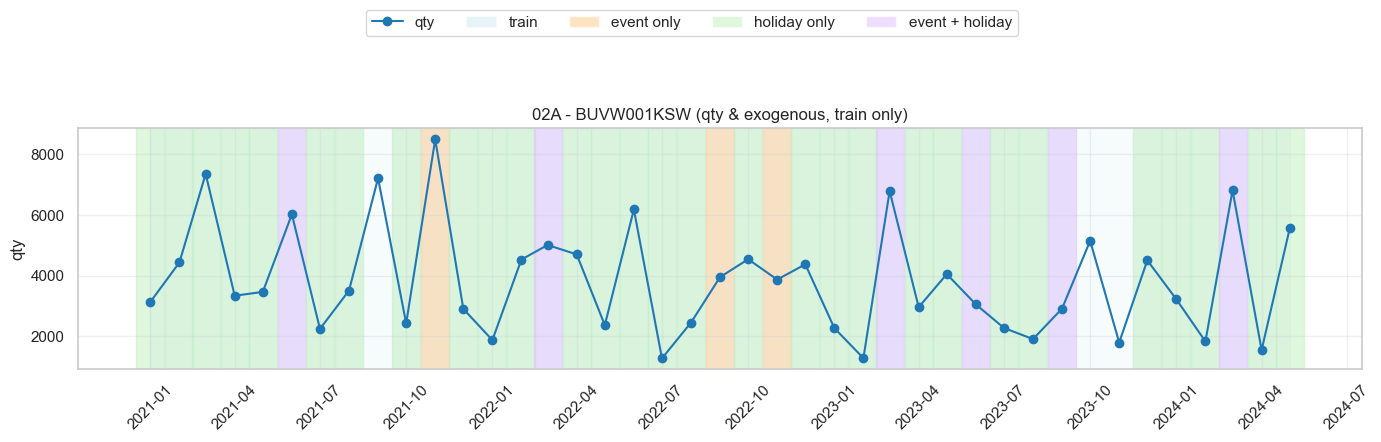

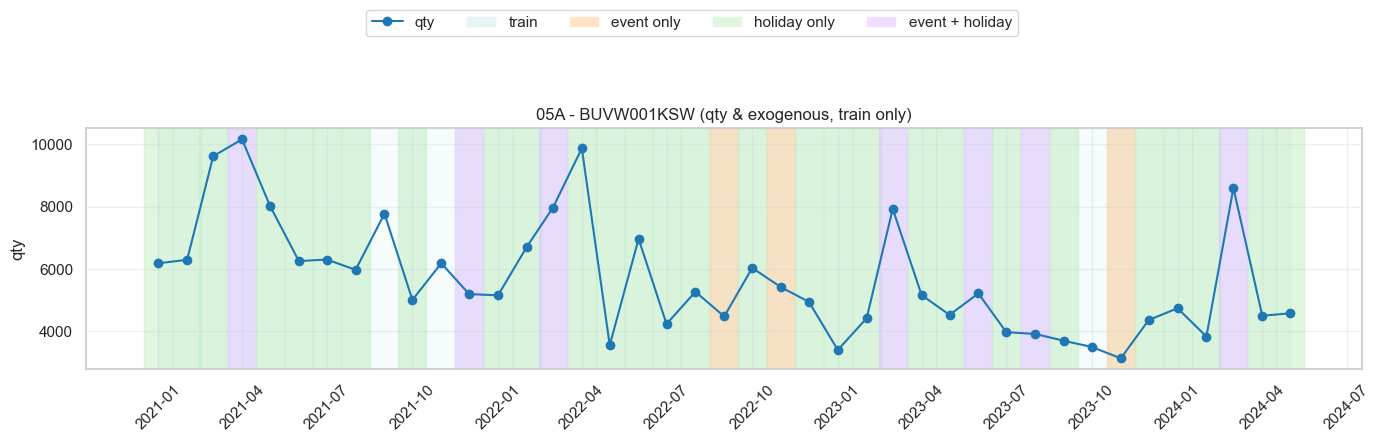

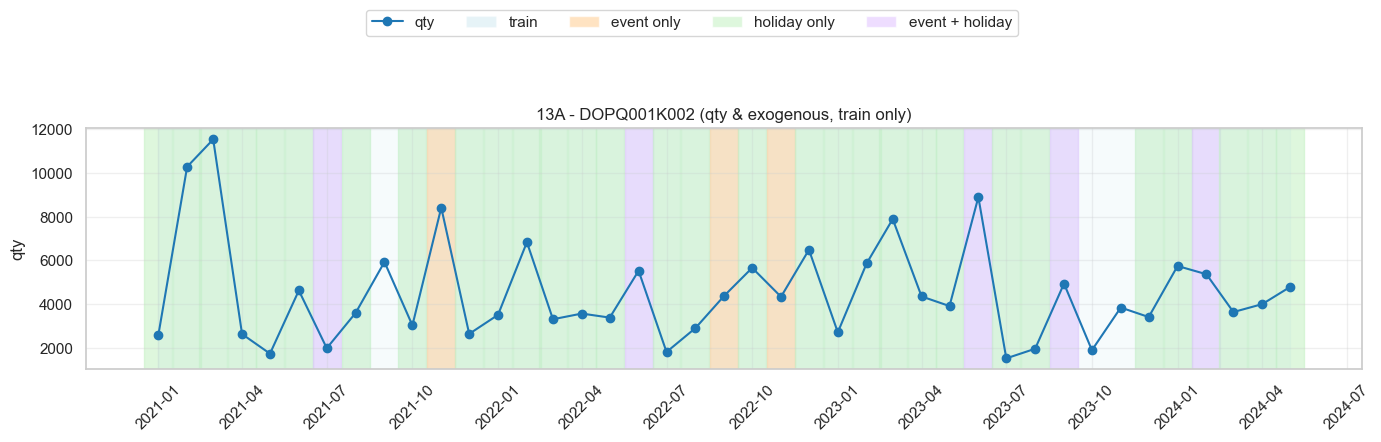

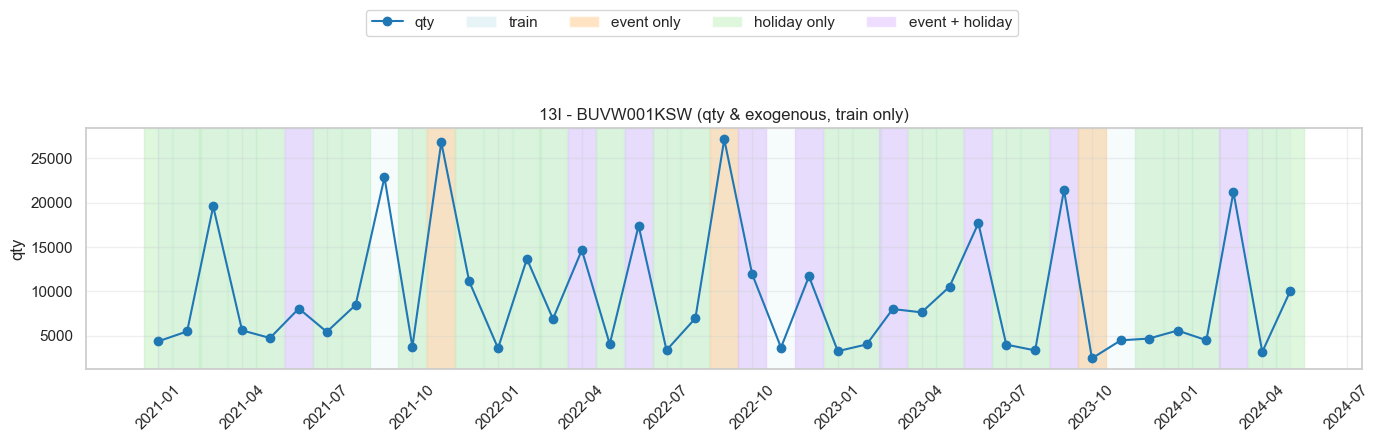

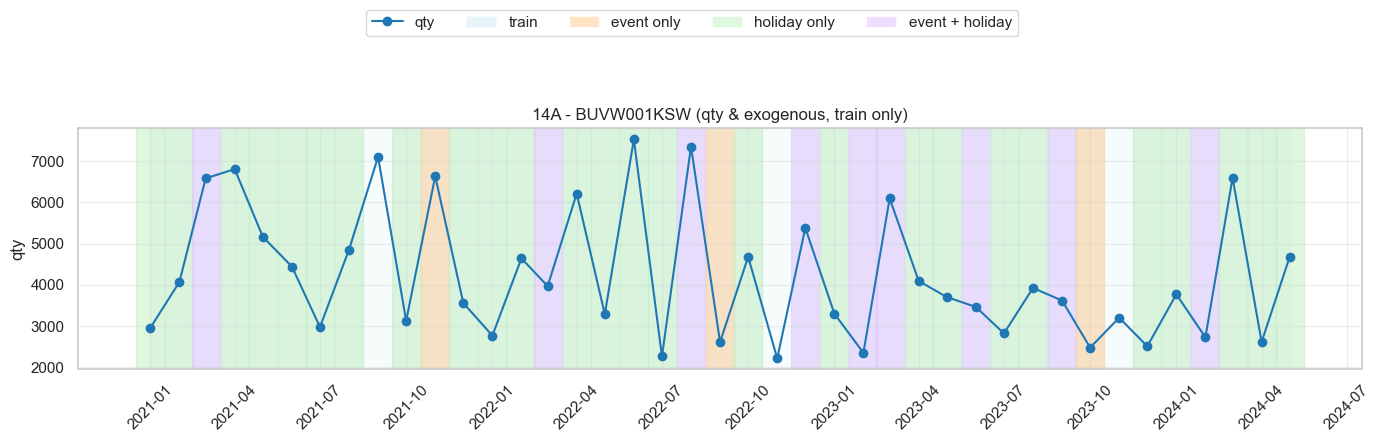

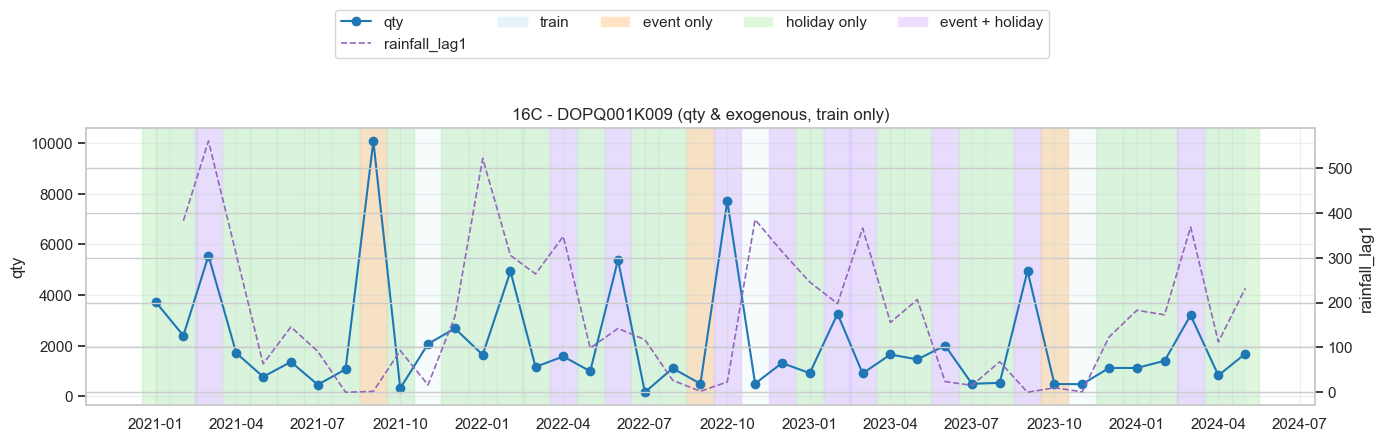

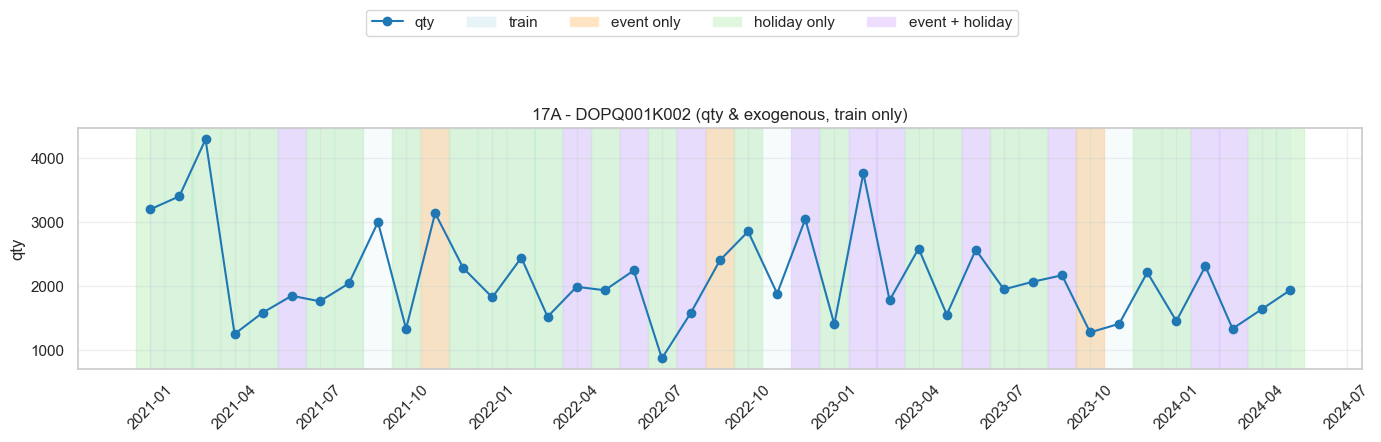

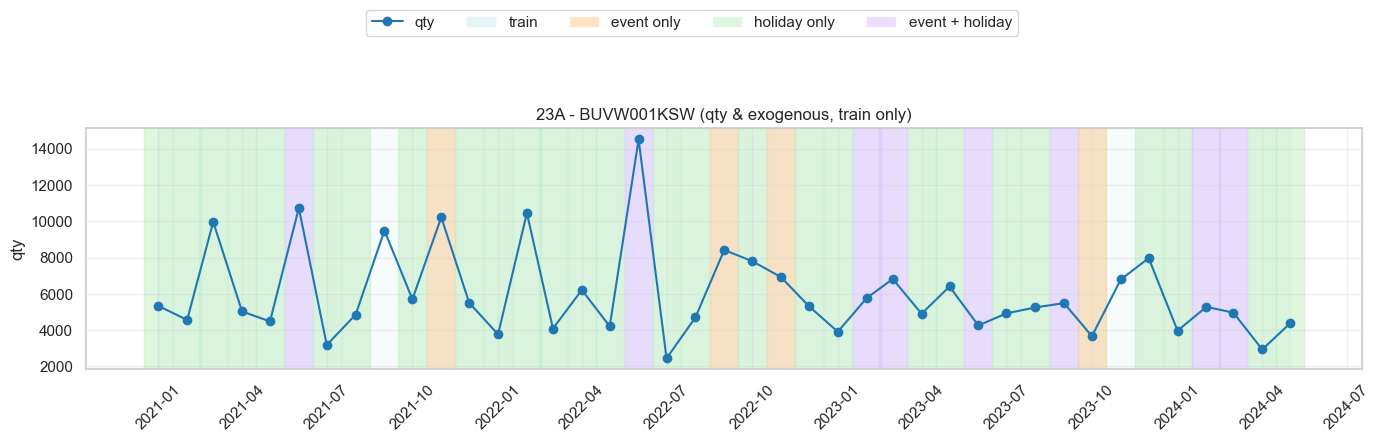

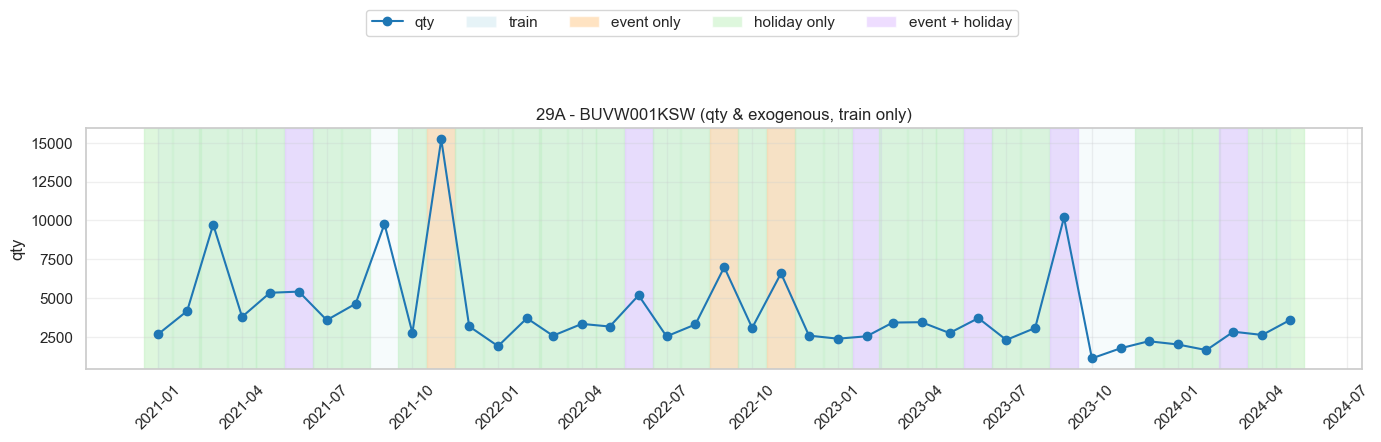

In [67]:
import matplotlib.dates as mdates
from datetime import timedelta
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_series_train_only(df, cabang, sku):
    train_end = pd.Timestamp("2024-05-01")

    g = df[(df["cabang"] == cabang) & (df["sku"] == sku)].sort_values("periode")

    # --- pake data train saja ---
    # kalau mau pakai flag:
    if "is_train" in g.columns:
        g = g[g["is_train"] == 1].copy()
    else:
        g = g[g["periode"] <= train_end].copy()

    fig, ax = plt.subplots(figsize=(14, 4))

    # ============= BACKGROUND TRAIN (full, karena cuma train) =============
    ax.axvspan(g["periode"].min(), g["periode"].max(),
               color="lightblue", alpha=0.10, label="train")

    # ============= BLOK EVENT / HOLIDAY =============
    half_month = pd.Timedelta(days=15)

    ex = (
        g[["periode", "event_flag", "holiday_count"]]
        .drop_duplicates("periode")
        .copy()
    )
    ex["event_flag"]   = (ex["event_flag"] > 0).astype(int)
    ex["holiday_flag"] = (ex["holiday_count"] > 0).astype(int)

    for _, row in ex.iterrows():
        p = row["periode"]
        e = row["event_flag"]
        h = row["holiday_flag"]

        if e == 0 and h == 0:
            continue
        if e == 1 and h == 0:
            color = "#FFD19A"   # event only
        elif e == 0 and h == 1:
            color = "#C9F2C7"   # holiday only
        else:
            color = "#E4C7FF"   # event + holiday

        ax.axvspan(p - half_month, p + half_month,
                   color=color, alpha=0.6, zorder=0.5)

    # ============= QTY =============
    line_qty, = ax.plot(
        g["periode"], g["qty"], marker="o",
        color="tab:blue", linewidth=1.5, label="qty", zorder=2
    )
    ax.set_ylabel("qty")
    ax.set_title(f"{cabang} - {sku} (qty & exogenous, train only)")

    # ============= RAINFALL (KHUSUS 16C) =============
    handles = [line_qty]
    labels  = ["qty"]

    if cabang == "16C" and "rainfall_lag1" in g.columns:
        ax2 = ax.twinx()
        line_rf, = ax2.plot(
            g["periode"], g["rainfall_lag1"],
            linestyle="--", color="tab:purple",
            linewidth=1.2, label="rainfall_lag1", zorder=1.5
        )
        ax2.set_ylabel("rainfall_lag1")
        handles.append(line_rf)
        labels.append("rainfall_lag1")

    ax.grid(alpha=0.3)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45)

    # ============= LEGEND =============
    legend_patches = [
        Patch(facecolor="lightblue", alpha=0.3, label="train"),
        Patch(facecolor="#FFD19A",  alpha=0.6, label="event only"),
        Patch(facecolor="#C9F2C7",  alpha=0.6, label="holiday only"),
        Patch(facecolor="#E4C7FF",  alpha=0.6, label="event + holiday"),
    ]

    fig.legend(
        handles + legend_patches,
        labels  + ["train", "event only", "holiday only", "event + holiday"],
        loc="upper center", bbox_to_anchor=(0.5, 1.12),
        ncol=5, frameon=True
    )

    plt.tight_layout(rect=(0, 0, 1, 0.90))
    plt.show()

for _, row in selected_9.iterrows():
    cab = row["cabang"]
    sku = row["sku"]
    plot_series_train_only(panel15, cab, sku)


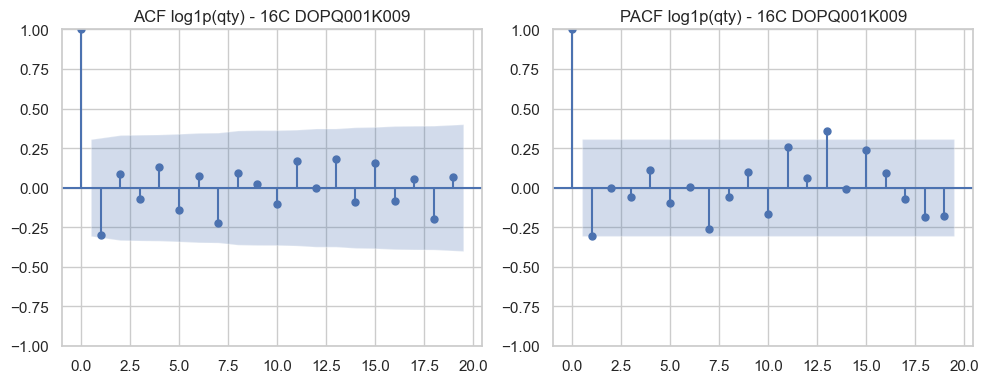


ADF log1p(qty)
  stat   : -8.530676906907818
  p-value: 1.039753814403554e-13

KPSS log1p(qty)
  stat   : 0.2680306108302164
  p-value: 0.1


In [68]:
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning

cab_exam = "16C"
sku_exam = "DOPQ001K009"

g = (
    panel15[(panel15["cabang"] == cab_exam) &
            (panel15["sku"] == sku_exam)]
    .sort_values("periode")
)

g_train = g[g["is_train"] == 1].copy()
y = np.log1p(g_train["qty"])

n = len(y)
max_lag = min(24, n // 2 - 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(y, ax=axes[0], lags=max_lag)
plot_pacf(y, ax=axes[1], lags=max_lag, method="yw")
axes[0].set_title(f"ACF log1p(qty) - {cab_exam} {sku_exam}")
axes[1].set_title(f"PACF log1p(qty) - {cab_exam} {sku_exam}")
plt.tight_layout()
plt.show()

# ====== suppress warning KPSS & teman2 ======
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=InterpolationWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    adf_res = adfuller(y, autolag="AIC")
    kpss_res = kpss(y, nlags="auto")

print("\nADF log1p(qty)")
print("  stat   :", adf_res[0])
print("  p-value:", adf_res[1])

print("\nKPSS log1p(qty)")
print("  stat   :", kpss_res[0])
print("  p-value:", kpss_res[1])


Buat modeling

In [24]:
from pathlib import Path
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller, acf

# =========================================
# PATH
# =========================================
PROJECT_ROOT     = Path(r"D:\Documents\Skripsi\demand-forecasting")
STD_DIR          = PROJECT_ROOT / "data" / "standardized"
DATASET15_DIR    = PROJECT_ROOT / "data" / "dataset_15"
DATASETFULL_DIR  = PROJECT_ROOT / "data" / "dataset_full"

panel_full_path  = STD_DIR       / "panel_model_eligible_all.csv"
panel15_path     = DATASET15_DIR / "panel_exog_selected15.csv"

panel_full = pd.read_csv(panel_full_path, parse_dates=["periode"])
panel15    = pd.read_csv(panel15_path,    parse_dates=["periode"])

print("panel_full rows:", len(panel_full))
print("panel15 rows    :", len(panel15))

# =========================================
# HELPERS: ADF / ACF / bucket / profiling
# =========================================

def safe_adf_pvalue(y):
    y = pd.to_numeric(y, errors="coerce").dropna()
    if len(y) < 12:
        return np.nan
    try:
        res = adfuller(y, autolag="AIC")
        return float(res[1])
    except Exception:
        return np.nan

def safe_acf_vals(y, nlags=24):
    y = pd.to_numeric(y, errors="coerce").dropna()
    if len(y) <= 2:
        return {}
    try:
        acf_vals = acf(y, nlags=min(nlags, len(y) - 2), fft=False, missing="conservative")
        out = {}
        for L in [1, 2, 3, 6, 12]:
            if L < len(acf_vals):
                out[f"acf_lag{L}"] = float(acf_vals[L])
            else:
                out[f"acf_lag{L}"] = np.nan
        return out
    except Exception:
        return {}

def profile_bucket_scale(m):
    if m < 5:
        return "low"
    elif m < 50:
        return "medium"
    else:
        return "high"

def profile_bucket_zero(z):
    if z <= 0.2:
        return "dense"
    elif z <= 0.5:
        return "semi_sparse"
    else:
        return "sparse"

def build_model_profiles(df: pd.DataFrame, label: str):
    """
    df: panel dengan kolom cabang, sku, periode, qty, is_train, spike_flag (opsional)
    return: DataFrame profil per (cabang, sku) dengan saran SARIMAX/LGBM/TFT
    """
    df_tr = df.query("is_train == 1").copy()
    df_tr = df_tr.sort_values(["cabang","sku","periode"])

    rows = []
    for (cab, sku), g in df_tr.groupby(["cabang","sku"], sort=False):
        g = g.sort_values("periode")
        y = g["qty"].astype(float)

        n_train = len(g)
        zero_ratio = float((y == 0).mean())
        qty_mean = float(y.mean())
        qty_median = float(y.median())
        qty_std = float(y.std(ddof=1))
        qty_max = float(y.max())
        spike_ratio = float(g["spike_flag"].mean()) if "spike_flag" in g.columns else np.nan

        # ADF
        adf_level = safe_adf_pvalue(y)
        adf_diff1 = safe_adf_pvalue(y.diff())

        # ACF
        acf_dict = safe_acf_vals(y, nlags=24)
        acf1  = acf_dict.get("acf_lag1", np.nan)
        acf12 = acf_dict.get("acf_lag12", np.nan)

        seasonal_flag = int(not np.isnan(acf12) and abs(acf12) >= 0.3)

        # ===== SARIMAX heuristik =====
        if np.isnan(adf_level) or np.isnan(adf_diff1):
            d_sug = 1
        else:
            if adf_level > 0.05 and adf_diff1 <= 0.05:
                d_sug = 1
            else:
                d_sug = 0

        D_sug = 1 if seasonal_flag == 1 else 0

        if not np.isnan(acf1) and abs(acf1) >= 0.5:
            sarimax_family = "AR_dominant"
        elif not np.isnan(acf1) and abs(acf1) <= 0.2:
            sarimax_family = "MA_or_low_AR"
        else:
            sarimax_family = "mixed"

        # ===== LGBM heuristik =====
        if n_train < 24:
            lgbm_size = "tiny"
            lgbm_max_depth = 4
            lgbm_num_leaves = 8
            lgbm_min_data_in_leaf = 5
        elif n_train < 48:
            lgbm_size = "small"
            lgbm_max_depth = 5
            lgbm_num_leaves = 16
            lgbm_min_data_in_leaf = 10
        elif n_train < 96:
            lgbm_size = "medium"
            lgbm_max_depth = 7
            lgbm_num_leaves = 32
            lgbm_min_data_in_leaf = 20
        else:
            lgbm_size = "large"
            lgbm_max_depth = 9
            lgbm_num_leaves = 64
            lgbm_min_data_in_leaf = 30

        # sparsity adjust
        if zero_ratio > 0.5:
            lgbm_min_data_in_leaf += 10
        if zero_ratio < 0.2 and qty_max > 200:
            lgbm_max_depth += 1

        # ===== TFT heuristik =====
        if n_train < 24 or zero_ratio > 0.7:
            tft_use = 0
            tft_encoder_len = np.nan
            tft_hidden_size = np.nan
        else:
            tft_use = 1
            tft_encoder_len = int(min(24, max(12, n_train - 6)))
            if qty_median < 5:
                tft_hidden_size = 8
            elif qty_median < 50:
                tft_hidden_size = 16
            else:
                tft_hidden_size = 32

        rows.append({
            "cabang": cab,
            "sku": sku,
            "dataset_label": label,
            "n_train": n_train,
            "zero_ratio": zero_ratio,
            "zero_bucket": profile_bucket_zero(zero_ratio),
            "qty_median": qty_median,
            "scale_bucket": profile_bucket_scale(qty_median),
            "qty_mean": qty_mean,
            "qty_std": qty_std,
            "qty_max": qty_max,
            "spike_ratio": spike_ratio,

            "adf_level_p": adf_level,
            "adf_diff1_p": adf_diff1,
            "acf_lag1": acf_dict.get("acf_lag1", np.nan),
            "acf_lag2": acf_dict.get("acf_lag2", np.nan),
            "acf_lag3": acf_dict.get("acf_lag3", np.nan),
            "acf_lag6": acf_dict.get("acf_lag6", np.nan),
            "acf_lag12": acf12,
            "seasonal_flag": seasonal_flag,

            "sarimax_d_sug": d_sug,
            "sarimax_D_sug": D_sug,
            "sarimax_family": sarimax_family,

            "lgbm_size_bucket": lgbm_size,
            "lgbm_max_depth_sug": lgbm_max_depth,
            "lgbm_num_leaves_sug": lgbm_num_leaves,
            "lgbm_min_data_in_leaf_sug": lgbm_min_data_in_leaf,

            "tft_use": tft_use,
            "tft_encoder_length_sug": tft_encoder_len,
            "tft_hidden_size_sug": tft_hidden_size,
        })

    return pd.DataFrame(rows)

# =========================================
# 1) PROFIL UNTUK DATASET FULL
# =========================================
profiles_full = build_model_profiles(panel_full, label="full")
profiles_full_path = DATASETFULL_DIR / "model_profiles_full.csv"
profiles_full.to_csv(profiles_full_path, index=False)
print("Saved model_profiles_full:", profiles_full_path)

summary_full_cbg = (
    profiles_full
    .groupby("cabang", as_index=False)
    .agg(
        n_sku=("sku","nunique"),
        median_zero_ratio=("zero_ratio","median"),
        median_n_train=("n_train","median"),
        frac_seasonal=("seasonal_flag","mean"),
        frac_tft_use=("tft_use","mean"),
        median_lgbm_max_depth=("lgbm_max_depth_sug","median"),
        median_lgbm_min_data_in_leaf=("lgbm_min_data_in_leaf_sug","median"),
    )
)
summary_full_path = DATASETFULL_DIR / "model_profiles_full_by_cabang.csv"
summary_full_cbg.to_csv(summary_full_path, index=False)
print("Saved model_profiles_full_by_cabang:", summary_full_path)

# =========================================
# 2) PROFIL UNTUK DATASET 15 SKU
# =========================================
profiles_15 = build_model_profiles(panel15, label="selected15")
profiles_15_path = DATASET15_DIR / "model_profiles_selected15.csv"
profiles_15.to_csv(profiles_15_path, index=False)
print("Saved model_profiles_selected15:", profiles_15_path)

summary_15_cbg = (
    profiles_15
    .groupby("cabang", as_index=False)
    .agg(
        n_sku=("sku","nunique"),
        median_zero_ratio=("zero_ratio","median"),
        median_n_train=("n_train","median"),
        frac_seasonal=("seasonal_flag","mean"),
        frac_tft_use=("tft_use","mean"),
        median_lgbm_max_depth=("lgbm_max_depth_sug","median"),
        median_lgbm_min_data_in_leaf=("lgbm_min_data_in_leaf_sug","median"),
    )
)
summary_15_path = DATASET15_DIR / "model_profiles_selected15_by_cabang.csv"
summary_15_cbg.to_csv(summary_15_path, index=False)
print("Saved model_profiles_selected15_by_cabang:", summary_15_path)




panel_full rows: 158863
panel15 rows    : 4965
Saved model_profiles_full: D:\Documents\Skripsi\demand-forecasting\data\dataset_full\model_profiles_full.csv
Saved model_profiles_full_by_cabang: D:\Documents\Skripsi\demand-forecasting\data\dataset_full\model_profiles_full_by_cabang.csv
Saved model_profiles_selected15: D:\Documents\Skripsi\demand-forecasting\data\dataset_15\model_profiles_selected15.csv
Saved model_profiles_selected15_by_cabang: D:\Documents\Skripsi\demand-forecasting\data\dataset_15\model_profiles_selected15_by_cabang.csv


In [25]:
import pandas as pd
from pathlib import Path

PROJECT_ROOT    = Path(r"D:\Documents\Skripsi\demand-forecasting")
DATASET15_DIR   = PROJECT_ROOT / "data" / "dataset_15"
DATASETFULL_DIR = PROJECT_ROOT / "data" / "dataset_full"

prof15  = pd.read_csv(DATASET15_DIR / "model_profiles_selected15.csv")
proffull = pd.read_csv(DATASETFULL_DIR / "model_profiles_full.csv")

print("Distribusi sarimax_d_sug (15 SKU):")
print(prof15["sarimax_d_sug"].value_counts())

print("\nSeasonal flag (15 SKU):")
print(prof15["seasonal_flag"].value_counts())

print("\nTFT_use (15 SKU):")
print(prof15["tft_use"].value_counts())


Distribusi sarimax_d_sug (15 SKU):
sarimax_d_sug
0    89
1    31
Name: count, dtype: int64

Seasonal flag (15 SKU):
seasonal_flag
0    100
1     20
Name: count, dtype: int64

TFT_use (15 SKU):
tft_use
1    120
Name: count, dtype: int64
